#Boston Data Housing


In [1]:
#Install dependencies
!pip install fastai
!pip install nbdev
!pip install ucimlrepo
!pip install /notebooks/pyade-master

#Import libraries
import pandas as pd
import numpy as np
import fastai
from fastai.tabular.all import *
import torch
import torch.nn.functional as F
import torch.nn as nn
import pickle
import copy
import time
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy import stats

#Connect to drive
#from google.colab import drive
#drive.mount('/content/drive')



#Convert and import personalised library
#!jupyter nbconvert --to python /content/drive/MyDrive/Colab\ Notebooks/utilsTFG.ipynb --output utilsTFG.py
#!cp /content/drive/MyDrive/Colab\ Notebooks/utilsTFG.py .
import sys
sys.path.append('/notebooks/utilstfg.py')
import utilstfg as utilsTFG

Processing ./pyade-master
  Preparing metadata (setup.py) ... done
  Created wheel for pyade-python: filename=pyade_python-1.0-py3-none-any.whl size=29472 sha256=968a5398f8a29b8a44098f8ec0f2ffabb9948bb93ce949b70b4467554700915f
  Stored in directory: /root/.cache/pip/wheels/98/25/f0/ab5adf3c6041d02e08073e288b6daf66206788126fdc60b442
Successfully built pyade-python
  Attempting uninstall: pyade-python
    Found existing installation: pyade-python 1.0
    Uninstalling pyade-python-1.0:
      Successfully uninstalled pyade-python-1.0


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

utilsTFG.set_seed()

cuda


### Datos y modelos

In [3]:
#For loading and restoring models
dataset= 'bhp'
plot_dataset='BHP'

#File name in drive path
filename = "/notebooks/data/HousingData.csv"


# data (as pandas dataframes)
df = pd.read_csv(filename)

#Show the data
print(df)

# Define the categorical and continuous variables
cat_names = []
cont_names = list(df.columns)

#Remove the target from the list of features
cont_names.remove('MEDV')

#Set the target
dep_var = 'MEDV'

#Show if there is missing data
missing_values = df.isna().sum()
print(missing_values)

#Handle the missing data, filling with the mean
mis_col = ['CRIM', 'ZN', 'INDUS', 'CHAS',  'AGE', 'LSTAT']
df[mis_col] = df[mis_col].fillna(df.mean())



        CRIM    ZN  INDUS  CHAS    NOX       RM   AGE        DIS  RAD  TAX  \
0    0.00632  18.0   2.31   0.0  538.0  6575.00  65.2     4.0900    1  296   
1    0.02731   0.0   7.07   0.0  469.0  6421.00  78.9     4.9671    2  242   
2    0.02729   0.0   7.07   0.0  469.0  7185.00  61.1     4.9671    2  242   
3    0.03237   0.0   2.18   0.0  458.0  6998.00  45.8     6.0622    3  222   
4    0.06905   0.0   2.18   0.0  458.0  7147.00  54.2     6.0622    3  222   
..       ...   ...    ...   ...    ...      ...   ...        ...  ...  ...   
501  0.06263   0.0  11.93   0.0  573.0  6593.00  69.1     2.4786    1  273   
502  0.04527   0.0  11.93   0.0  573.0     6.12  76.7     2.2875    1  273   
503  0.06076   0.0  11.93   0.0  573.0  6976.00  91.0     2.1675    1  273   
504  0.10959   0.0  11.93   0.0  573.0  6794.00  89.3     2.3889    1  273   
505  0.04741   0.0  11.93   0.0  573.0     6.03   NaN  2505.0000    1  273   

     PTRATIO       B  LSTAT  MEDV  
0       15.3  396.90   4.98

In [4]:
# Split indices for training, validation, and test sets
train_val_split = RandomSplitter(valid_pct=0.3, seed=42)(range_of(df))  # 70% for training/validation, 30% for testing
train_idx, val_test_idx = train_val_split

# Now split the validation/test set into validation and test sets (~20% test ~10% validation)
val_test_split = RandomSplitter(valid_pct=0.7, seed=42)(val_test_idx)
val_idx, test_idx = val_test_split

# Combine all indices for the splits
splits = (train_idx, val_idx)

# Create DataFrames for the splits
train_df = df.iloc[train_idx]
val_df = df.iloc[val_idx]
test_df = df.iloc[test_idx]

MEDV       1.000000
LSTAT      0.728235
PTRATIO    0.473712
INDUS      0.464043
TAX        0.459794
AGE        0.378580
RAD        0.375615
ZN         0.372038
B          0.310048
CHAS       0.200225
RM         0.158213
NOX        0.114400
DIS        0.088420
CRIM       0.064812
dtype: float64


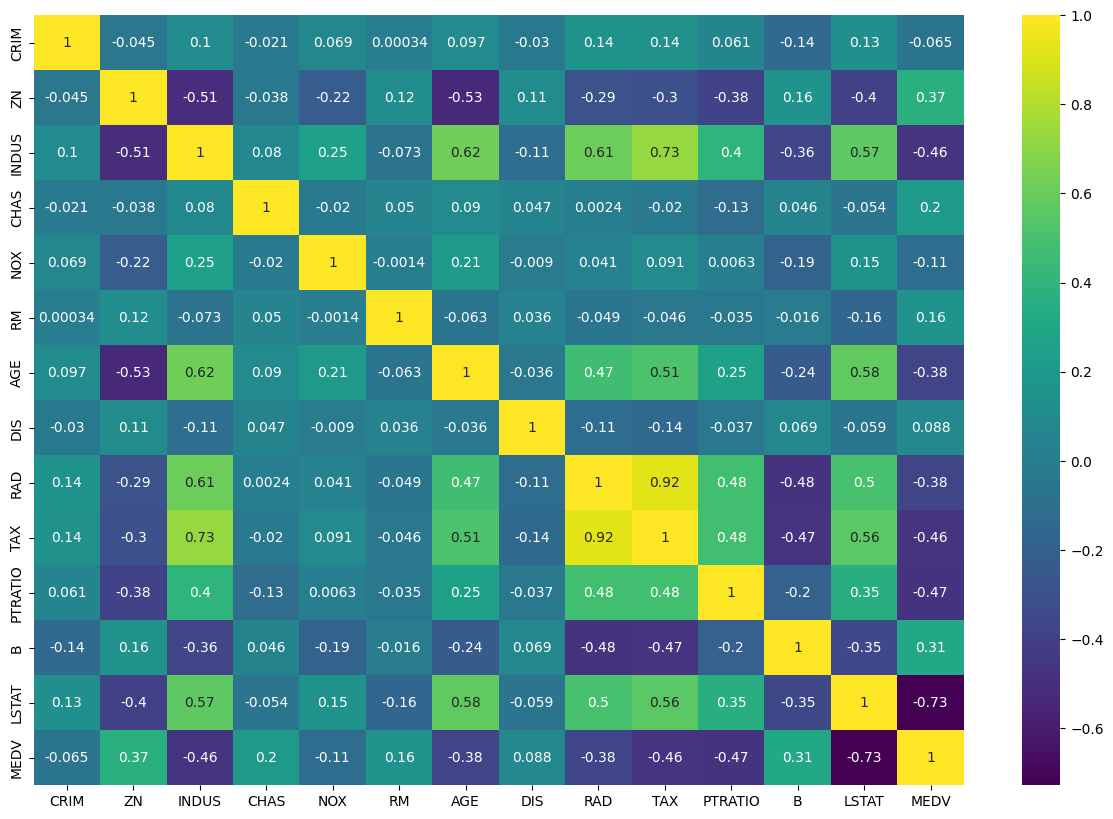

In [5]:
##Preprocessing

#Correlation of all features with the target
corr_mat = train_df.corr()[dep_var]
target_corr = np.abs(train_df.corrwith(train_df[dep_var]))
print(target_corr.sort_values(ascending=False))

#Correlation of features with each other
corr_matrix = train_df.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix,cmap="viridis", annot=True)
plt.show()

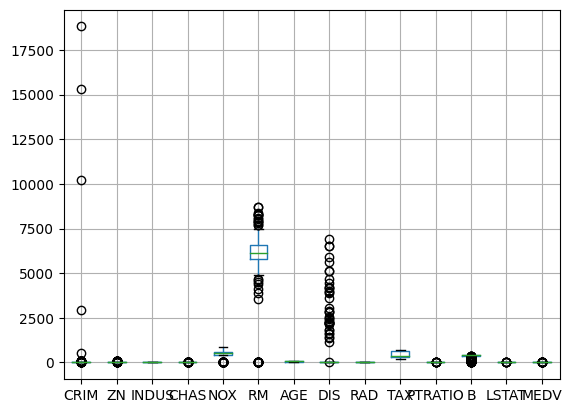

In [6]:
#Boxplot to see the range of feature values
train_df.boxplot()
plt.show()

In [7]:
#Drop features with low correlation with the target
features_to_drop = target_corr[target_corr < 0.1].index
train_df = train_df.drop(columns=features_to_drop)
val_df = val_df.drop(columns=features_to_drop)
test_df = test_df.drop(columns=features_to_drop)
cont_names = [col for col in cont_names if col not in features_to_drop]
print(f"Variables eliminadas: {features_to_drop}")

Variables eliminadas: Index(['CRIM', 'DIS'], dtype='object')


In [8]:
# Correlation matrix of the training set
corr_matrix = train_df.corr()
threshold = 0.9

# Find pairs of features with correlation above the threshold
high_corr_pairs = [(i, j) for i in corr_matrix.columns for j in corr_matrix.columns if i != j and corr_matrix.loc[i, j] > threshold]

to_drop = set()

for i, j in high_corr_pairs:
    if i not in to_drop and j not in to_drop:
        # Add one of the features to the drop list
        to_drop.add(j)

# Drop the identified features from the DataFrames
train_df.drop(columns=to_drop, inplace=True)
val_df.drop(columns=to_drop, inplace=True)
test_df.drop(columns=to_drop, inplace=True)

# Update the list of continuous names
cont_names = [col for col in cont_names if col not in to_drop]

# Print the dropped features for reference
print(f"Variables eliminadas: {to_drop}")

Variables eliminadas: {'TAX'}


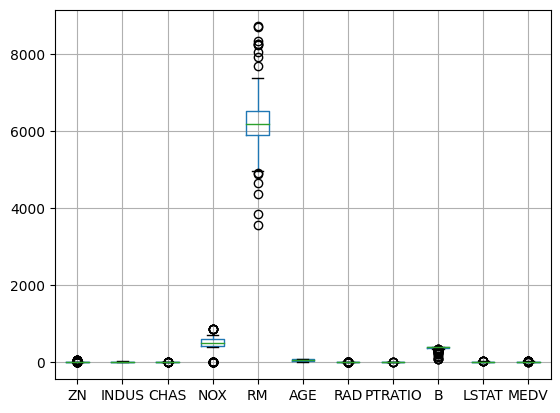

In [9]:
#Remove outliers
mean = train_df.mean()
std = train_df.std()

z_score_train = ((train_df - mean) / std )
z_score_val = ((val_df - mean) / std )
z_score_test = ((test_df - mean) / std )

outliers_train = (np.abs(z_score_train) > 3 ).any(axis=1)
outliers_val = (np.abs(z_score_val) > 3 ).any(axis=1)
outliers_test = (np.abs(z_score_test) > 3 ).any(axis=1)


train_df_no_outliers = train_df[~outliers_train]
val_df_no_outliers = val_df[~outliers_val]
test_df_no_outliers = test_df[~outliers_test]

train_df_no_outliers.boxplot()
plt.show()

In [10]:
# Normalize the continuous features
scaler = StandardScaler()

# Fit the scaler on the training data and transform the training data
train_df_no_outliers.loc[:,cont_names] = scaler.fit_transform(train_df_no_outliers.loc[:,cont_names])

# Transform the validation and test data
val_df_no_outliers.loc[:,cont_names] = scaler.transform(val_df_no_outliers.loc[:,cont_names])
test_df_no_outliers.loc[:,cont_names] = scaler.transform(test_df_no_outliers.loc[:,cont_names])


train_df_no_outliers = train_df_no_outliers.reset_index(drop=True)
val_df_no_outliers = val_df_no_outliers.reset_index(drop=True)

# Combine all indices for the splits
splits = (list(train_df_no_outliers.index), list(val_df_no_outliers.index))

# Concatenate the DataFrames back together
df_c = pd.concat([train_df_no_outliers, val_df_no_outliers])

# Create TabularPandas for training and validation
to = TabularPandas(
    df_c,
    procs=[Categorify],
    cat_names=cat_names,
    cont_names=cont_names,
    y_names=dep_var,
    splits=splits
)

# Create DataLoaders for training and validation
dls = to.dataloaders(bs=64, shuffle=True)

# Create TabularPandas for the test set
test_to = TabularPandas(
    test_df_no_outliers,  # Select only the test data
    procs=[Categorify],
    cat_names=cat_names,
    cont_names=cont_names,
    y_names=dep_var
)

# Create a DataLoader for the test set. Dont shuffle to get a more objective value across computations
test_dl = test_to.dataloaders(bs=64, shuffle=False)
dls.to(device)
test_dl.to(device)

/tmp/ipykernel_516099/3673551083.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.52479874 -0.64374101 -0.52479874 -0.52479874 -0.52479874 -0.52479874
 -0.16797192  1.73510448 -0.52479874  1.73510448 -0.52479874 -0.64374101
 -0.76268329 -0.76268329 -0.28691419  1.73510448  1.73510448  1.73510448
 -0.28691419  1.73510448 -0.40585646 -0.64374101 -0.52479874 -0.40585646
 -0.52479874  1.73510448 -0.16797192 -0.52479874 -0.76268329 -0.16797192
 -0.88162556  1.73510448  1.73510448 -0.64374101 -0.52479874 -0.76268329
 -0.52479874  1.73510448 -0.64374101  1.73510448 -0.52479874 -0.52479874
 -0.64374101 -0.52479874  1.73510448 -0.64374101 -0.52479874  1.73510448
 -0.64374101 -0.64374101 -0.52479874 -0.88162556 -0.52479874 -0.16797192
 -0.76268329  1.73510448 -0.52479874  1.73510448 -0.16797192 -0.76268329
 -0.76268329 -0.16797192  1.73510448 -0.52479874 -1.00056784 -0.64374101
 -0.52479874 -0.40585646  1.73510448 -0.

In [11]:
#Initialise arrays for the loops
layers = [[64], [64, 64], [ 64, 128, 256, 128, 64], [32, 64, 128, 256, 512, 1024, 512, 256, 128, 64, 32] ]
n_layers=[1,2,5,11]
optims = ['NAG', 'RMSProp', 'ADAM', 'ADAMW']
names_layer=['1 capa', '2 capas', '5 capas', '11 capas']
algs = ['SHADE', 'SHADE-ILS', 'SHADE-GD', 'SHADE-ILS-GD']
metric = ['AdjR2Sq']
init_weights = {}
for layer in n_layers:
  init_weights[layer] = {}

In [12]:
#For each number of layers initialise the model with the same parameters.
for layer in layers:
  learn = tabular_learner(dls, layers=layer, n_out=1, metrics=utilsTFG.AdjustedR2Score, loss_func=MSELossFlat())
  learn.model.apply(utilsTFG.init_weights_glorot)
  learn.to(device)
  init_weights[len(layer)] = utilsTFG.get_params_from_model(learn.model)

  print(learn.summary())

TabularModel (Input shape: 64 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 10             
BatchNorm1d                               20         True      
____________________________________________________________________________
                     64 x 64             
Linear                                    640        True      
ReLU                                                           
BatchNorm1d                               128        True      
____________________________________________________________________________
                     64 x 1              
Linear                                    65         True      
____________________________________________________________________________

Total params: 853
Total trainable params: 853
Total non-trainable params: 0

Optimizer used: <function Adam at 0x7fbe56cb6c00>
Loss function: FlattenedLoss of MSELoss()

Callbacks:
  - TrainEvalCallback
  - CastToTensor
  -

TabularModel (Input shape: 64 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 10             
BatchNorm1d                               20         True      
____________________________________________________________________________
                     64 x 64             
Linear                                    640        True      
ReLU                                                           
BatchNorm1d                               128        True      
Linear                                    4096       True      
ReLU                                                           
BatchNorm1d                               128        True      
____________________________________________________________________________
                     64 x 1              
Linear                                    65         True      
____________________________________________________________________________

Total params: 5,077
Total train

TabularModel (Input shape: 64 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 10             
BatchNorm1d                               20         True      
____________________________________________________________________________
                     64 x 64             
Linear                                    640        True      
ReLU                                                           
BatchNorm1d                               128        True      
____________________________________________________________________________
                     64 x 128            
Linear                                    8192       True      
ReLU                                                           
BatchNorm1d                               256        True      
____________________________________________________________________________
                     64 x 256            
Linear                                    32768      T

TabularModel (Input shape: 64 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 10             
BatchNorm1d                               20         True      
____________________________________________________________________________
                     64 x 32             
Linear                                    320        True      
ReLU                                                           
BatchNorm1d                               64         True      
____________________________________________________________________________
                     64 x 64             
Linear                                    2048       True      
ReLU                                                           
BatchNorm1d                               128        True      
____________________________________________________________________________
                     64 x 128            
Linear                                    8192       T

## Gradient Descent

In [13]:
# Define the optimizers
NAG = partial(OptimWrapper, opt=torch.optim.SGD, momentum=0.9, nesterov=True)
RMSProp = partial(OptimWrapper, opt=torch.optim.RMSprop)
ADAM = partial(OptimWrapper, opt=torch.optim.Adam)
ADAMW = partial(OptimWrapper, opt=torch.optim.AdamW)
optims2 = [NAG, RMSProp, ADAM, ADAMW]
utilsTFG.set_seed()

# Initialize the learners dictionary
learners = {}
time_gd = {}
epochs=20

# Iterate over the optimizers and layers to create learners
for opt, opt2 in zip(optims, optims2):
    learners[opt] = {}  # Initialize the dictionary for this optimizer
    time_gd[opt] = {}
    for layer in layers:
        learners[opt][len(layer)] = tabular_learner(dls=dls, layers=layer, n_out=1, loss_func = MSELossFlat(), metrics=utilsTFG.AdjustedR2Score, opt_func=opt2, cbs=[SaveModelCallback()])
        learners[opt][len(layer)].to(device)
        learners[opt][len(layer)].model.to(device)
        utilsTFG.set_params_to_model(init_weights[len(layer)], learners[opt][len(layer)].model)


In [14]:
#To check if the models have the same initial parameters
for layer in n_layers:
  if utilsTFG.compare_models(learners['NAG'][layer], learners['RMSProp'][layer]) and utilsTFG.compare_models(learners['NAG'][layer], learners['ADAM'][layer]) and utilsTFG.compare_models(learners['ADAM'][layer], learners['RMSProp'][layer]):
    print(f"Mismos parámetros en capa {layer}.")
  else:
    print("Distintos parámetros.")


Mismos parámetros en capa 1.
Mismos parámetros en capa 2.
Mismos parámetros en capa 5.
Mismos parámetros en capa 11.


### Nesterov

Better model found at epoch 0 with valid_loss value: 502.0096130371094.
Better model found at epoch 1 with valid_loss value: 493.3441467285156.
Better model found at epoch 2 with valid_loss value: 463.0714111328125.
Better model found at epoch 3 with valid_loss value: 415.09234619140625.
Better model found at epoch 4 with valid_loss value: 363.7279052734375.
Better model found at epoch 5 with valid_loss value: 303.2120056152344.
Better model found at epoch 6 with valid_loss value: 238.43772888183594.
Better model found at epoch 7 with valid_loss value: 166.73902893066406.
Better model found at epoch 8 with valid_loss value: 106.05955505371094.
Better model found at epoch 9 with valid_loss value: 62.68365478515625.
Better model found at epoch 10 with valid_loss value: 33.417022705078125.
Better model found at epoch 11 with valid_loss value: 19.050004959106445.
Better model found at epoch 12 with valid_loss value: 11.974013328552246.
Better model found at epoch 13 with valid_loss value: 

Better model found at epoch 0 with valid_loss value: 511.9205627441406.
Better model found at epoch 1 with valid_loss value: 505.4143981933594.
Better model found at epoch 2 with valid_loss value: 482.2267761230469.
Better model found at epoch 3 with valid_loss value: 443.1259460449219.
Better model found at epoch 4 with valid_loss value: 404.64288330078125.
Better model found at epoch 5 with valid_loss value: 354.8685302734375.
Better model found at epoch 6 with valid_loss value: 304.3311462402344.
Better model found at epoch 7 with valid_loss value: 238.25753784179688.
Better model found at epoch 8 with valid_loss value: 179.0654296875.
Better model found at epoch 9 with valid_loss value: 130.38186645507812.
Better model found at epoch 10 with valid_loss value: 88.24858856201172.
Better model found at epoch 11 with valid_loss value: 57.753543853759766.
Better model found at epoch 12 with valid_loss value: 34.922454833984375.
Better model found at epoch 13 with valid_loss value: 20.94

Better model found at epoch 0 with valid_loss value: 508.2605285644531.
Better model found at epoch 1 with valid_loss value: 498.5638122558594.
Better model found at epoch 2 with valid_loss value: 474.49517822265625.
Better model found at epoch 3 with valid_loss value: 435.08111572265625.
Better model found at epoch 4 with valid_loss value: 396.7529296875.
Better model found at epoch 5 with valid_loss value: 347.7649230957031.
Better model found at epoch 6 with valid_loss value: 299.9988708496094.
Better model found at epoch 7 with valid_loss value: 235.86483764648438.
Better model found at epoch 8 with valid_loss value: 182.3142547607422.
Better model found at epoch 9 with valid_loss value: 138.6228790283203.
Better model found at epoch 10 with valid_loss value: 95.46804809570312.
Better model found at epoch 11 with valid_loss value: 61.959835052490234.
Better model found at epoch 12 with valid_loss value: 37.9582633972168.
Better model found at epoch 13 with valid_loss value: 20.6985

Better model found at epoch 0 with valid_loss value: 510.7810363769531.
Better model found at epoch 1 with valid_loss value: 500.28204345703125.
Better model found at epoch 2 with valid_loss value: 481.5540771484375.
Better model found at epoch 3 with valid_loss value: 458.43359375.
Better model found at epoch 4 with valid_loss value: 421.23779296875.
Better model found at epoch 5 with valid_loss value: 368.53521728515625.
Better model found at epoch 6 with valid_loss value: 314.6770324707031.
Better model found at epoch 7 with valid_loss value: 245.5787811279297.
Better model found at epoch 8 with valid_loss value: 192.1673126220703.
Better model found at epoch 9 with valid_loss value: 140.2699737548828.
Better model found at epoch 10 with valid_loss value: 100.97298431396484.
Better model found at epoch 11 with valid_loss value: 70.74713134765625.
Better model found at epoch 12 with valid_loss value: 42.50081253051758.
Better model found at epoch 13 with valid_loss value: 26.34428596

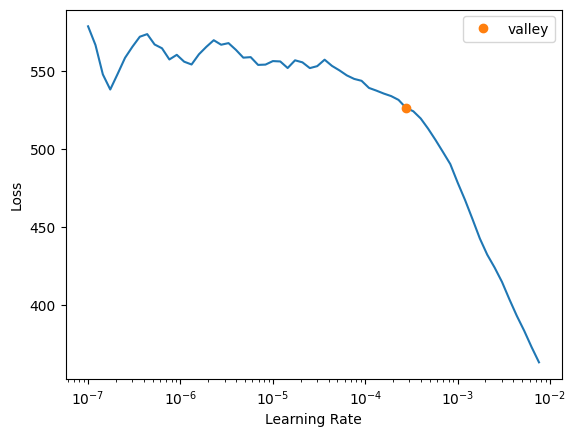

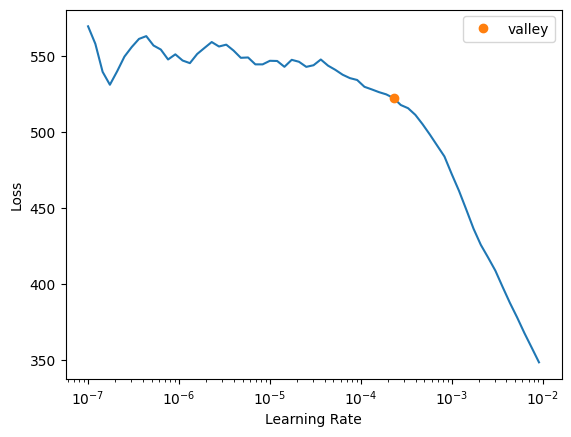

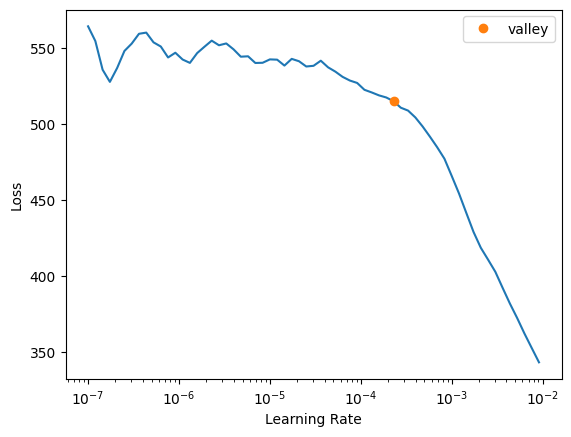

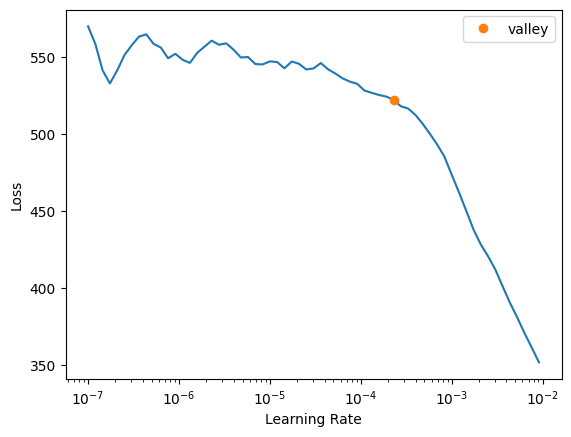

In [18]:
#Run the training and measure the time for each layer
for layer, learner in learners['NAG'].items():
  utilsTFG.set_seed()
  lr=learner.lr_find()
  start = time.perf_counter()
  learner.fit_one_cycle(epochs, lr)
  end = time.perf_counter()
  time_gd['NAG'][layer] = end-start



<Figure size 1200x600 with 0 Axes>

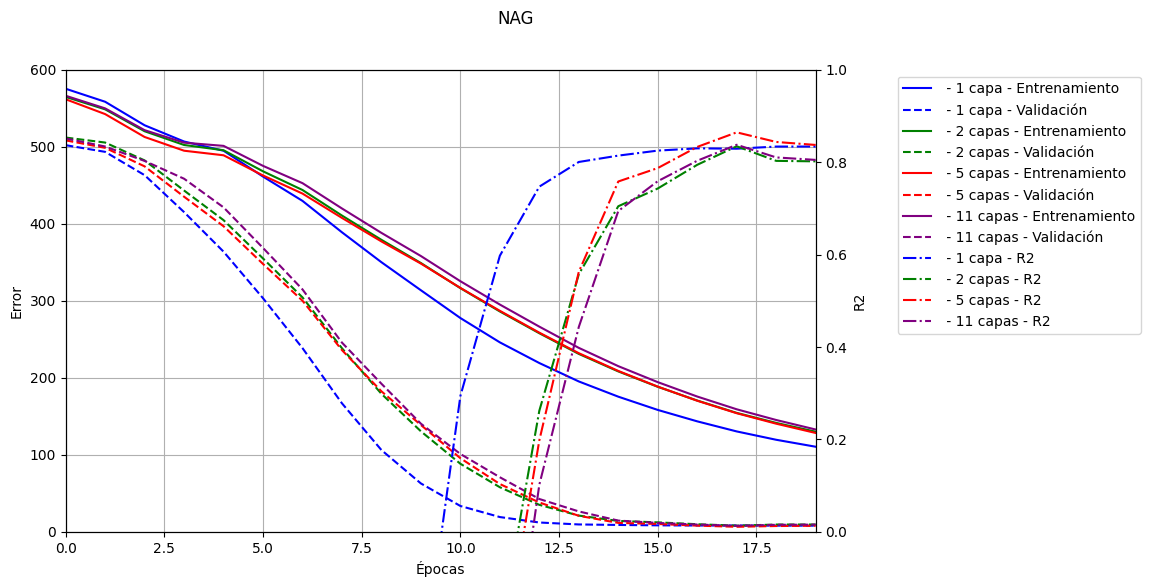

In [41]:
#Plot the grafic for all layers combined
utilsTFG.plot_learners_training(learners['NAG'].values(), title='NAG', lim=600, names=names_layer, metric=metric)

### RMSProp

Better model found at epoch 0 with valid_loss value: 492.8919372558594.
Better model found at epoch 1 with valid_loss value: 428.5528869628906.
Better model found at epoch 2 with valid_loss value: 290.491455078125.
Better model found at epoch 3 with valid_loss value: 64.6555404663086.
Better model found at epoch 5 with valid_loss value: 15.92406177520752.
Better model found at epoch 8 with valid_loss value: 14.053812980651855.
Better model found at epoch 9 with valid_loss value: 12.283098220825195.
Better model found at epoch 11 with valid_loss value: 9.319374084472656.
Better model found at epoch 12 with valid_loss value: 8.133162498474121.
Better model found at epoch 13 with valid_loss value: 7.546711444854736.
Better model found at epoch 14 with valid_loss value: 7.526445388793945.


Better model found at epoch 0 with valid_loss value: 491.55963134765625.
Better model found at epoch 1 with valid_loss value: 409.0104675292969.
Better model found at epoch 2 with valid_loss value: 231.6698760986328.
Better model found at epoch 3 with valid_loss value: 64.09549713134766.
Better model found at epoch 6 with valid_loss value: 12.891176223754883.
Better model found at epoch 10 with valid_loss value: 6.561678886413574.
Better model found at epoch 11 with valid_loss value: 5.222723007202148.
Better model found at epoch 14 with valid_loss value: 5.172912120819092.
Better model found at epoch 15 with valid_loss value: 4.888136386871338.
Better model found at epoch 18 with valid_loss value: 4.746940612792969.
Better model found at epoch 19 with valid_loss value: 4.6758294105529785.


Better model found at epoch 0 with valid_loss value: 499.51458740234375.
Better model found at epoch 1 with valid_loss value: 408.7906799316406.
Better model found at epoch 4 with valid_loss value: 322.76763916015625.
Better model found at epoch 5 with valid_loss value: 187.6090850830078.
Better model found at epoch 6 with valid_loss value: 14.319001197814941.
Better model found at epoch 11 with valid_loss value: 12.499858856201172.
Better model found at epoch 12 with valid_loss value: 6.066232681274414.
Better model found at epoch 13 with valid_loss value: 3.514002799987793.


Better model found at epoch 0 with valid_loss value: 512.3214111328125.
Better model found at epoch 7 with valid_loss value: 225.5917205810547.
Better model found at epoch 8 with valid_loss value: 101.03195190429688.
Better model found at epoch 9 with valid_loss value: 40.5755615234375.
Better model found at epoch 11 with valid_loss value: 33.5251350402832.
Better model found at epoch 12 with valid_loss value: 21.689510345458984.
Better model found at epoch 13 with valid_loss value: 8.97990894317627.
Better model found at epoch 14 with valid_loss value: 5.9913201332092285.
Better model found at epoch 15 with valid_loss value: 4.689682483673096.
Better model found at epoch 16 with valid_loss value: 4.143786430358887.
Better model found at epoch 18 with valid_loss value: 4.0502424240112305.
Better model found at epoch 19 with valid_loss value: 3.687253952026367.


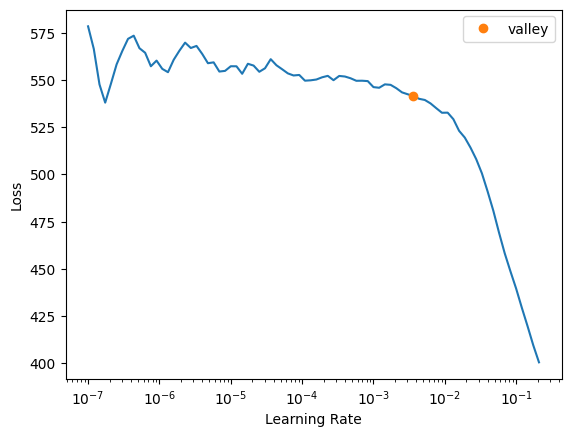

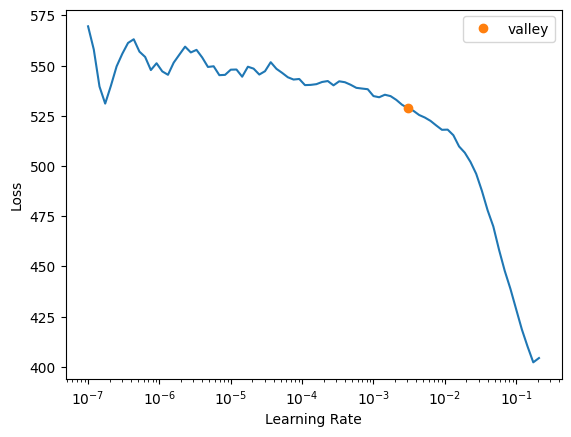

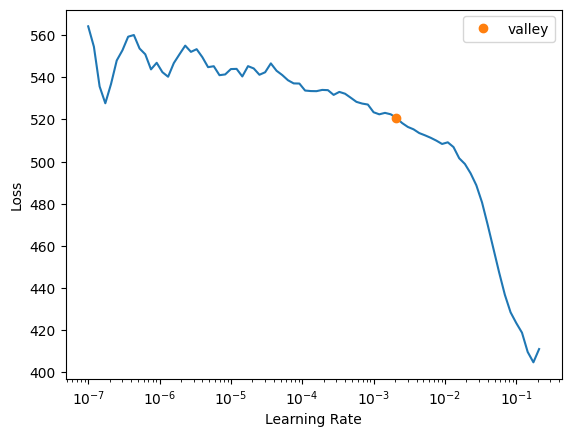

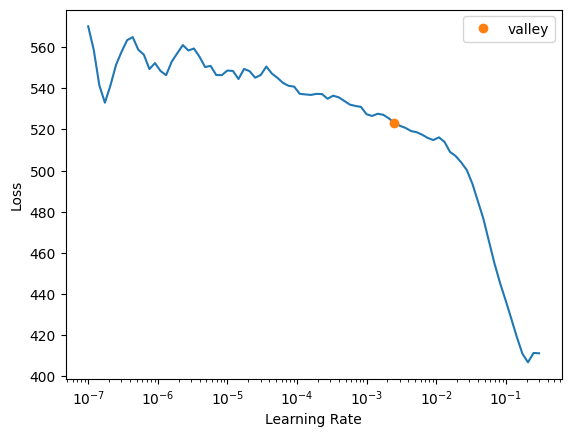

In [20]:
#Run the training and measure the time for each layer
for layer, learner in learners['RMSProp'].items():
  utilsTFG.set_seed()
  lr=learner.lr_find()
  start = time.perf_counter()
  learner.fit_one_cycle(epochs, lr)
  end = time.perf_counter()
  time_gd['RMSProp'][layer] = end-start


<Figure size 1200x600 with 0 Axes>

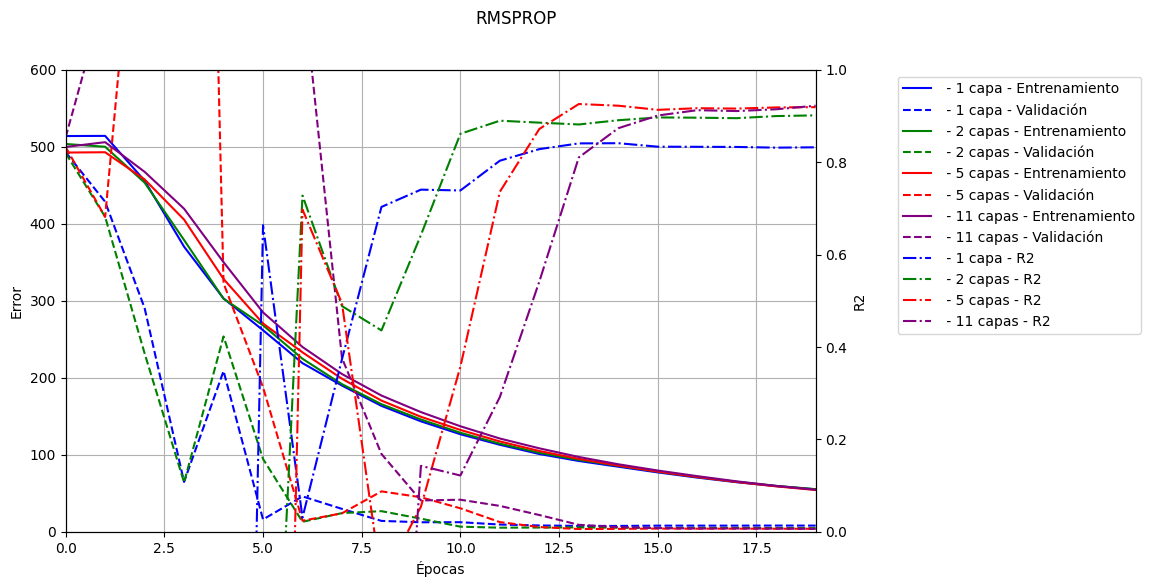

In [40]:
#Plot the grafic for all layers combined
utilsTFG.plot_learners_training(learners['RMSProp'].values(), title='RMSPROP', lim=600, names=names_layer, metric=metric)

### Adam

Better model found at epoch 0 with valid_loss value: 501.9619445800781.
Better model found at epoch 1 with valid_loss value: 498.0844421386719.
Better model found at epoch 2 with valid_loss value: 484.04998779296875.
Better model found at epoch 3 with valid_loss value: 465.6017761230469.
Better model found at epoch 4 with valid_loss value: 438.595703125.
Better model found at epoch 5 with valid_loss value: 400.9322204589844.
Better model found at epoch 6 with valid_loss value: 358.8690185546875.
Better model found at epoch 7 with valid_loss value: 306.0437316894531.
Better model found at epoch 8 with valid_loss value: 223.8543243408203.
Better model found at epoch 9 with valid_loss value: 138.7450408935547.
Better model found at epoch 10 with valid_loss value: 90.71319580078125.
Better model found at epoch 11 with valid_loss value: 55.03065490722656.
Better model found at epoch 12 with valid_loss value: 30.315732955932617.
Better model found at epoch 13 with valid_loss value: 19.436983

Better model found at epoch 0 with valid_loss value: 509.6977233886719.
Better model found at epoch 1 with valid_loss value: 502.26251220703125.
Better model found at epoch 2 with valid_loss value: 485.0960388183594.
Better model found at epoch 3 with valid_loss value: 469.03466796875.
Better model found at epoch 4 with valid_loss value: 443.06329345703125.
Better model found at epoch 5 with valid_loss value: 392.41607666015625.
Better model found at epoch 6 with valid_loss value: 345.7476806640625.
Better model found at epoch 7 with valid_loss value: 299.7750549316406.
Better model found at epoch 8 with valid_loss value: 244.59120178222656.
Better model found at epoch 9 with valid_loss value: 174.3178253173828.
Better model found at epoch 10 with valid_loss value: 147.1876220703125.
Better model found at epoch 11 with valid_loss value: 121.32449340820312.
Better model found at epoch 12 with valid_loss value: 85.58289337158203.
Better model found at epoch 13 with valid_loss value: 62.4

Better model found at epoch 0 with valid_loss value: 506.4457092285156.
Better model found at epoch 1 with valid_loss value: 491.3043518066406.
Better model found at epoch 2 with valid_loss value: 472.80279541015625.
Better model found at epoch 3 with valid_loss value: 471.2041320800781.
Better model found at epoch 4 with valid_loss value: 434.5638122558594.
Better model found at epoch 5 with valid_loss value: 409.1585693359375.
Better model found at epoch 6 with valid_loss value: 391.990234375.
Better model found at epoch 7 with valid_loss value: 363.4284973144531.
Better model found at epoch 8 with valid_loss value: 347.9204406738281.
Better model found at epoch 9 with valid_loss value: 308.05755615234375.
Better model found at epoch 10 with valid_loss value: 266.5807800292969.
Better model found at epoch 11 with valid_loss value: 265.9975891113281.
Better model found at epoch 12 with valid_loss value: 245.06094360351562.
Better model found at epoch 13 with valid_loss value: 212.7103

Better model found at epoch 0 with valid_loss value: 509.5017395019531.
Better model found at epoch 1 with valid_loss value: 500.267333984375.
Better model found at epoch 2 with valid_loss value: 481.92437744140625.
Better model found at epoch 3 with valid_loss value: 464.1477355957031.
Better model found at epoch 9 with valid_loss value: 398.7951965332031.
Better model found at epoch 10 with valid_loss value: 280.6580505371094.
Better model found at epoch 11 with valid_loss value: 271.1411437988281.
Better model found at epoch 12 with valid_loss value: 211.14117431640625.
Better model found at epoch 13 with valid_loss value: 165.1842041015625.
Better model found at epoch 14 with valid_loss value: 145.2617950439453.
Better model found at epoch 15 with valid_loss value: 132.81675720214844.
Better model found at epoch 16 with valid_loss value: 126.24506378173828.


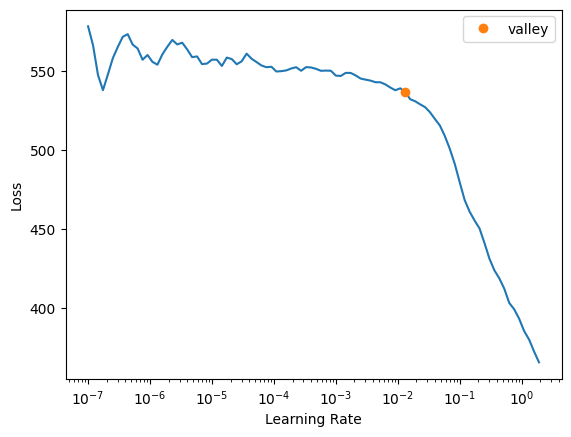

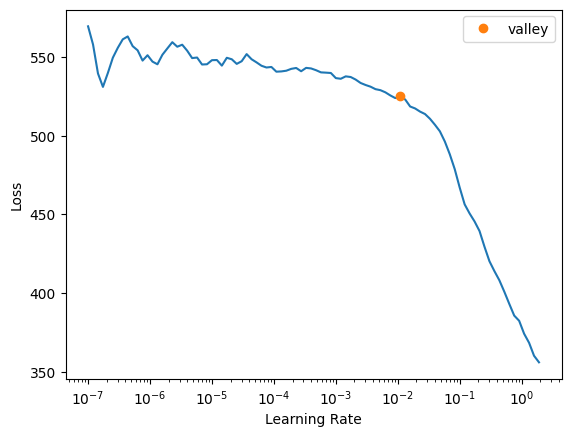

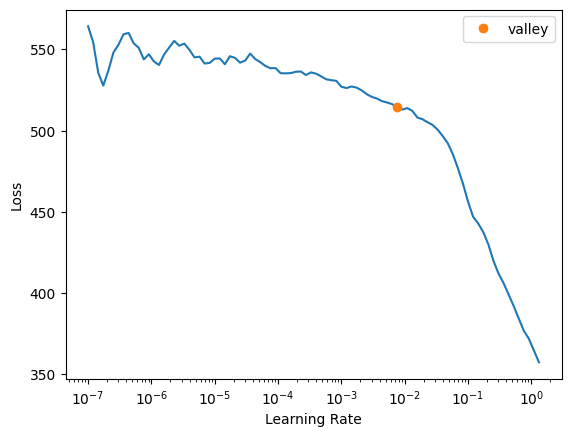

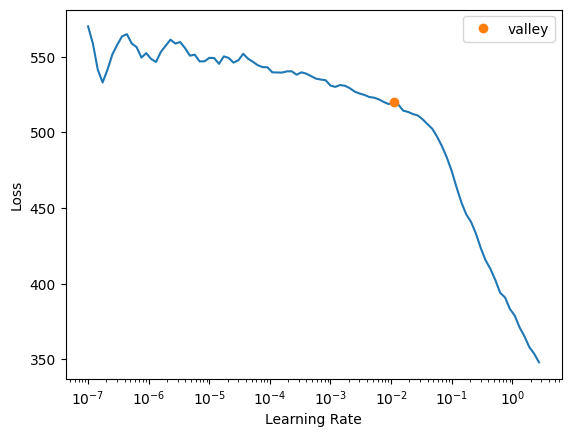

In [22]:
#Run the training and measure the time for each layer
for layer, learner in learners['ADAM'].items():
  utilsTFG.set_seed()
  lr=learner.lr_find()
  start = time.perf_counter()
  learner.fit_one_cycle(epochs, lr)
  end = time.perf_counter()
  time_gd['ADAM'][layer] = end-start


<Figure size 1200x600 with 0 Axes>

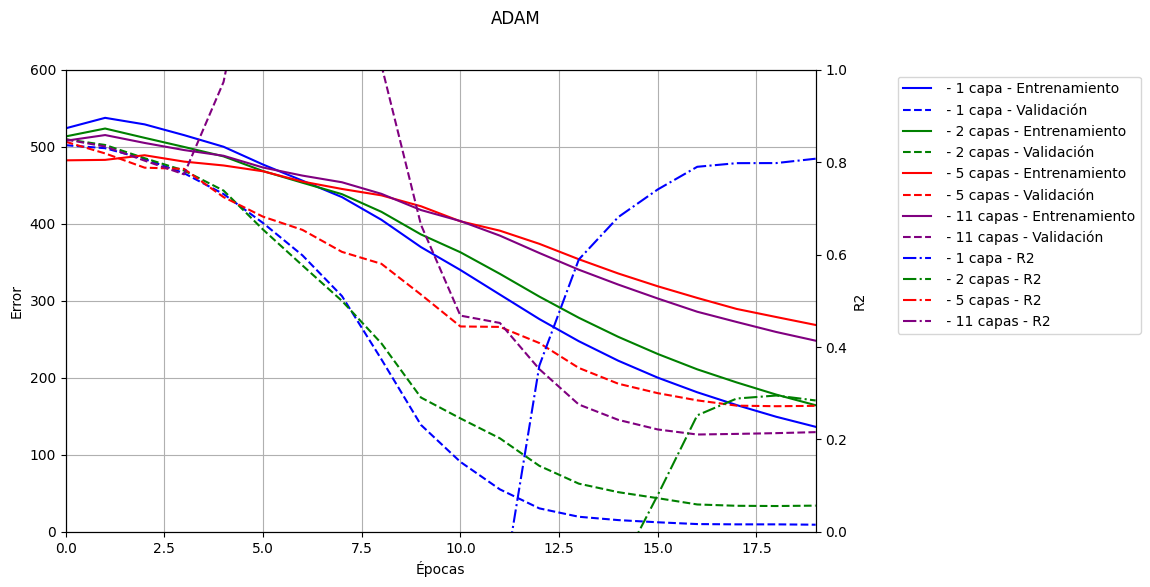

In [39]:
#Plot the grafic for all layers combined
utilsTFG.plot_learners_training(learners['ADAM'].values(), title='ADAM', lim=600, names=names_layer, metric=metric)

### AdamW

Better model found at epoch 0 with valid_loss value: 501.9632263183594.
Better model found at epoch 1 with valid_loss value: 498.0918884277344.
Better model found at epoch 2 with valid_loss value: 484.0818176269531.
Better model found at epoch 3 with valid_loss value: 465.6739807128906.
Better model found at epoch 4 with valid_loss value: 438.7189025878906.
Better model found at epoch 5 with valid_loss value: 401.1641540527344.
Better model found at epoch 6 with valid_loss value: 359.2641906738281.
Better model found at epoch 7 with valid_loss value: 306.5718078613281.
Better model found at epoch 8 with valid_loss value: 224.5914764404297.
Better model found at epoch 9 with valid_loss value: 139.61798095703125.
Better model found at epoch 10 with valid_loss value: 91.5197982788086.
Better model found at epoch 11 with valid_loss value: 55.71604537963867.
Better model found at epoch 12 with valid_loss value: 30.83070945739746.
Better model found at epoch 13 with valid_loss value: 19.7944

Better model found at epoch 0 with valid_loss value: 509.21923828125.
Better model found at epoch 1 with valid_loss value: 499.48919677734375.
Better model found at epoch 2 with valid_loss value: 482.6391296386719.
Better model found at epoch 3 with valid_loss value: 463.91290283203125.
Better model found at epoch 4 with valid_loss value: 443.8193664550781.
Better model found at epoch 5 with valid_loss value: 397.3624267578125.
Better model found at epoch 6 with valid_loss value: 334.5715026855469.
Better model found at epoch 7 with valid_loss value: 286.8423156738281.
Better model found at epoch 8 with valid_loss value: 245.6887969970703.
Better model found at epoch 9 with valid_loss value: 193.6028594970703.
Better model found at epoch 10 with valid_loss value: 129.5393829345703.
Better model found at epoch 11 with valid_loss value: 107.74861907958984.
Better model found at epoch 12 with valid_loss value: 89.80253601074219.
Better model found at epoch 13 with valid_loss value: 66.362

Better model found at epoch 0 with valid_loss value: 505.43695068359375.
Better model found at epoch 1 with valid_loss value: 489.2171936035156.
Better model found at epoch 2 with valid_loss value: 476.35406494140625.
Better model found at epoch 3 with valid_loss value: 448.99908447265625.
Better model found at epoch 4 with valid_loss value: 427.7978820800781.
Better model found at epoch 5 with valid_loss value: 413.7118835449219.
Better model found at epoch 6 with valid_loss value: 371.65411376953125.
Better model found at epoch 7 with valid_loss value: 316.2030029296875.
Better model found at epoch 8 with valid_loss value: 258.497802734375.
Better model found at epoch 9 with valid_loss value: 215.49734497070312.
Better model found at epoch 10 with valid_loss value: 155.19198608398438.
Better model found at epoch 11 with valid_loss value: 118.66426086425781.
Better model found at epoch 12 with valid_loss value: 75.11652374267578.
Better model found at epoch 13 with valid_loss value: 4

Better model found at epoch 0 with valid_loss value: 509.502197265625.
Better model found at epoch 1 with valid_loss value: 500.27142333984375.
Better model found at epoch 2 with valid_loss value: 482.1014709472656.
Better model found at epoch 3 with valid_loss value: 465.21282958984375.
Better model found at epoch 9 with valid_loss value: 444.84625244140625.
Better model found at epoch 10 with valid_loss value: 332.42266845703125.
Better model found at epoch 11 with valid_loss value: 272.8520812988281.
Better model found at epoch 12 with valid_loss value: 216.07008361816406.
Better model found at epoch 13 with valid_loss value: 180.0415496826172.
Better model found at epoch 14 with valid_loss value: 160.11000061035156.
Better model found at epoch 15 with valid_loss value: 149.9929962158203.
Better model found at epoch 16 with valid_loss value: 143.13912963867188.
Better model found at epoch 17 with valid_loss value: 141.86012268066406.
Better model found at epoch 18 with valid_loss va

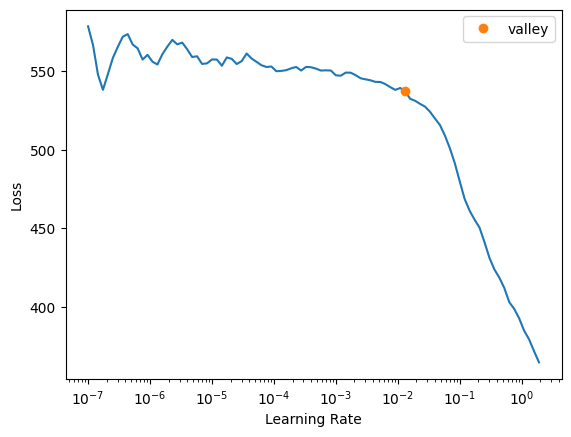

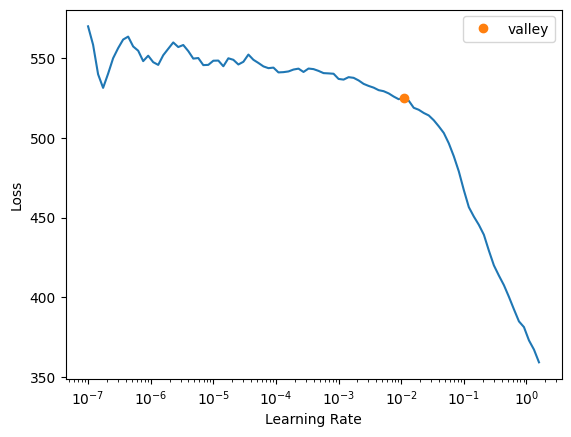

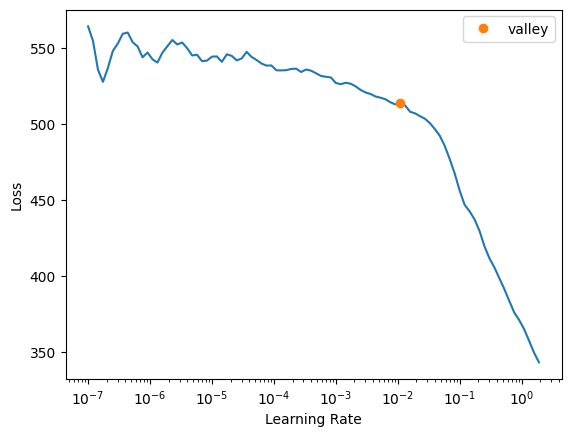

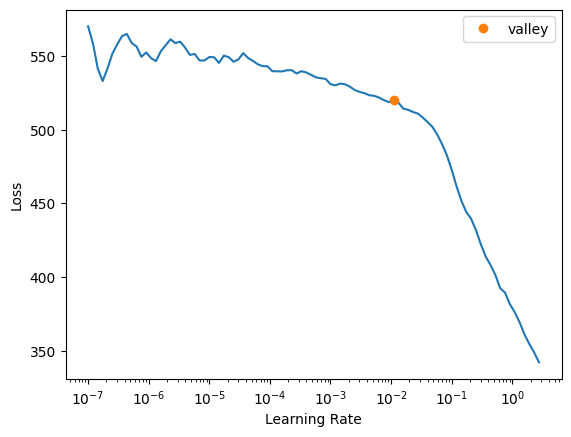

In [25]:
#Run the training and measure the time for each layer
for layer, learner in learners['ADAMW'].items():
  utilsTFG.set_seed()
  lr=learner.lr_find()
  start = time.perf_counter()
  learner.fit_one_cycle(epochs, lr)
  end = time.perf_counter()
  time_gd['ADAMW'][layer] = end-start


<Figure size 1200x600 with 0 Axes>

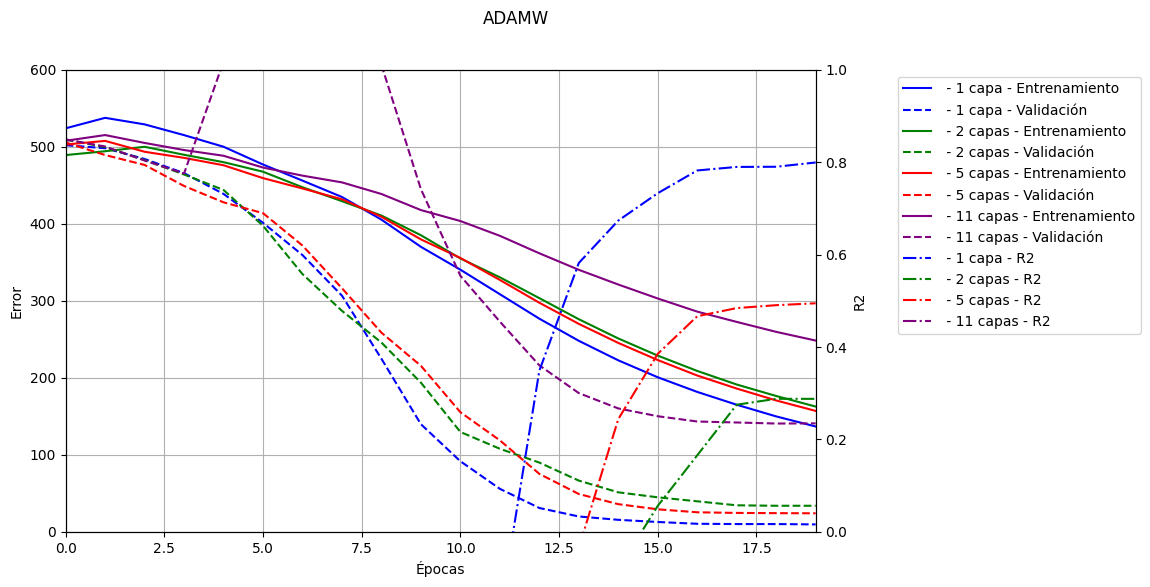

In [38]:
#Plot the grafic for all layers combined
utilsTFG.plot_learners_training(learners['ADAMW'].values(), title='ADAMW', lim=600, names=names_layer, metric=metric)

### Save or Load models

In [27]:
#Save learner with their losses and metrics
for optim in optims:
  for layer in n_layers:
    file_path = f'/notebooks/saved_models/learner_{dataset}_{layer}_{optim}.pkl'
    with open(file_path, 'wb') as f:
        pickle.dump({'learner': learners[optim][layer], 'recorder_values': learners[optim][layer].recorder.values}, f)


In [28]:
file_path = f'/notebooks/saved_models/learner_times_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(time_gd, f)

In [35]:
#Load learner with their losses and metrics
for optim in optims:
  for layer in n_layers:
    file_path = f'/notebooks/saved_models/learner_{dataset}_{layer}_{optim}.pkl'
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    learners[optim][layer], learners[optim][layer].recorder.values = data['learner'], data['recorder_values']
file_path = f'/notebooks/saved_models/learner_times_{dataset}.pkl'
with open(file_path, 'rb') as f:
    time_gd = pickle.load(f)

### Comparative per layers

<Figure size 1200x600 with 0 Axes>

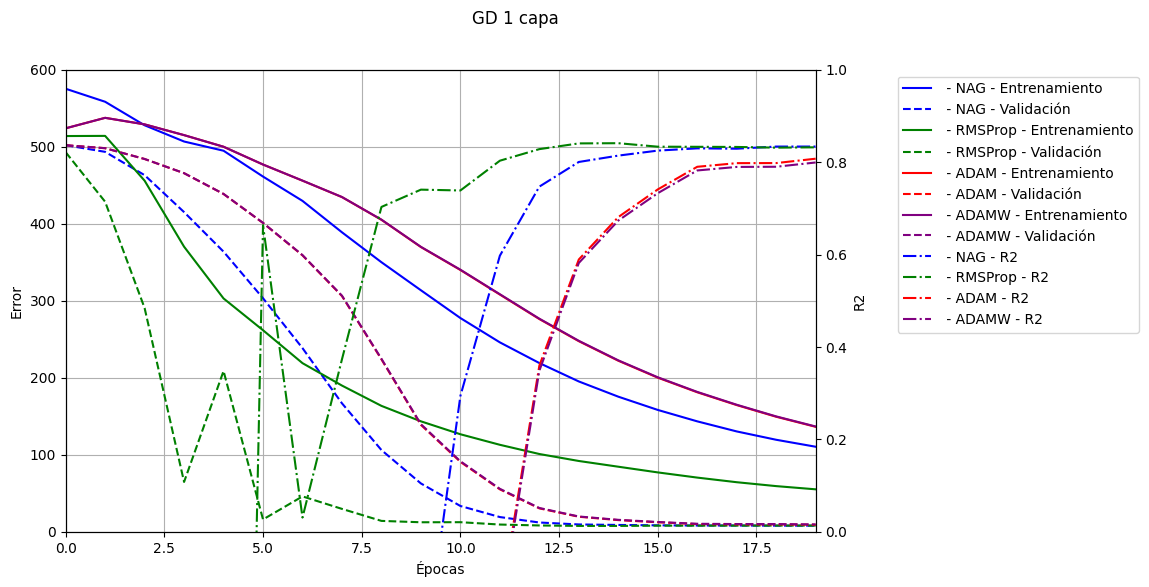

<Figure size 1200x600 with 0 Axes>

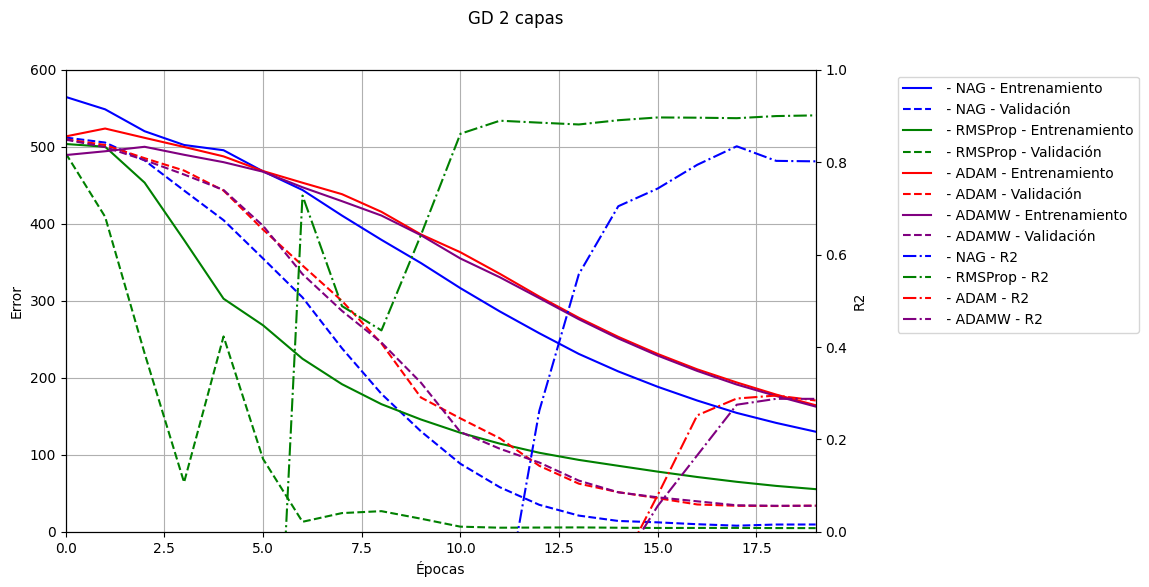

<Figure size 1200x600 with 0 Axes>

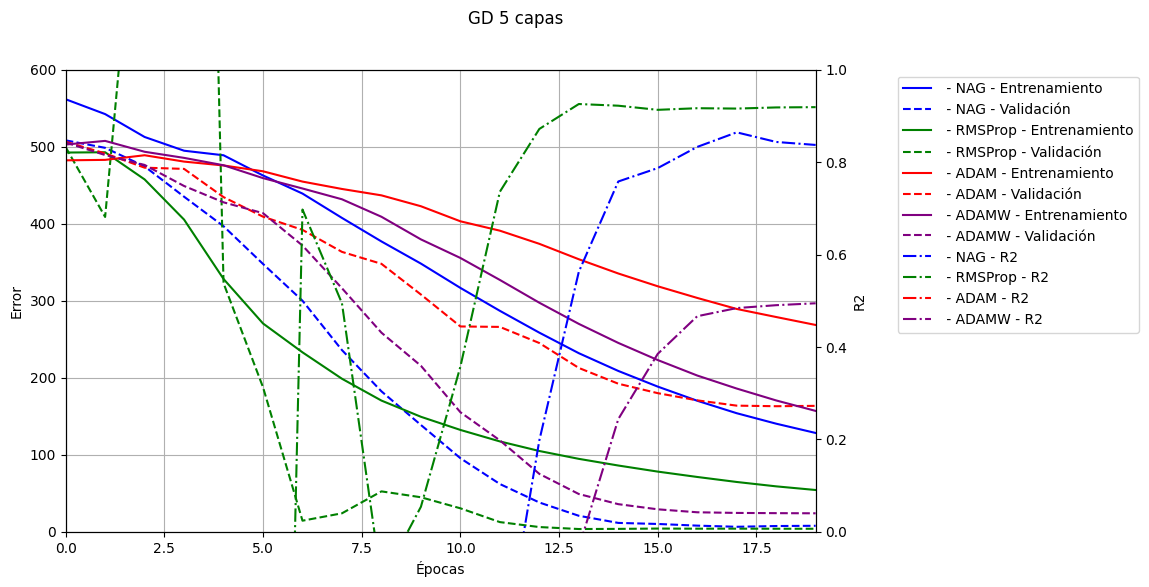

<Figure size 1200x600 with 0 Axes>

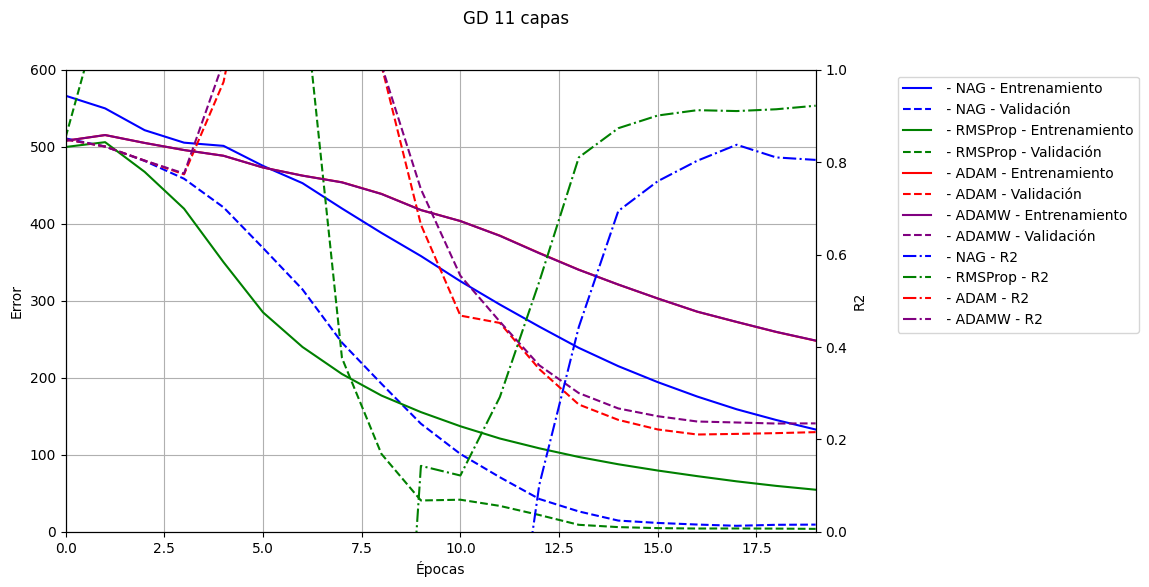

In [32]:
#Compare the three optimizers for each layer

learners_1_layer = [learners['NAG'][1], learners['RMSProp'][1], learners['ADAM'][1], learners['ADAMW'][1] ]
learners_2_layers = [learners['NAG'][2], learners['RMSProp'][2], learners['ADAM'][2], learners['ADAMW'][2]]
learners_5_layers = [learners['NAG'][5], learners['RMSProp'][5], learners['ADAM'][5], learners['ADAMW'][5]]
learners_11_layers = [learners['NAG'][11], learners['RMSProp'][11], learners['ADAM'][11], learners['ADAMW'][11]]

names=['NAG', 'RMSProp', 'ADAM', 'ADAMW']
utilsTFG.plot_learners_training(learners_1_layer, lim=600, title='GD 1 capa', names=names, metric=metric)
utilsTFG.plot_learners_training(learners_2_layers, lim=600, title='GD 2 capas', names=names, metric=metric)
utilsTFG.plot_learners_training(learners_5_layers, lim=600, title='GD 5 capas', names=names, metric=metric)
utilsTFG.plot_learners_training(learners_11_layers, lim=600, title='GD 11 capas', names=names, metric=metric)

### Generalization

In [33]:
#Run the model in the test set
for optim in optims:
  for layer in n_layers:
    #Run the model with optimizer optim and n_layers layer the test set in evaluation mode
    learners[optim][layer].model.eval()
    learners[optim][layer].eval()
    preds, targs = learners[optim][layer].get_preds(dl=test_dl)
    targs = targs.long().squeeze()



    #Calculate Adjusted R2 Square

    r2 = utilsTFG.adjusted_r2_score(preds.squeeze(), targs)

    #Calculate loss
    loss = utilsTFG.err_param_w_model(learners[optim][layer].model, test_dl, mode = 'test', task='reg')


    print(f"Optimizer: {optim}, Layers: {layer}, Loss: {loss}, Adjusted R2 Square: {r2}")

Optimizer: NAG, Layers: 1, Loss: 5.659790992736816, Adjusted R2 Square: 0.8208928610847197


Optimizer: NAG, Layers: 2, Loss: 4.977007865905762, Adjusted R2 Square: 0.8366633104186636


Optimizer: NAG, Layers: 5, Loss: 3.8486545085906982, Adjusted R2 Square: 0.8582861312373695


Optimizer: NAG, Layers: 11, Loss: 5.16170072555542, Adjusted R2 Square: 0.782117803617051


Optimizer: RMSProp, Layers: 1, Loss: 6.332393646240234, Adjusted R2 Square: 0.7900425936097634


Optimizer: RMSProp, Layers: 2, Loss: 4.5774922370910645, Adjusted R2 Square: 0.832402434983986


Optimizer: RMSProp, Layers: 5, Loss: 3.5110790729522705, Adjusted R2 Square: 0.8475534640124476


Optimizer: RMSProp, Layers: 11, Loss: 3.2686407566070557, Adjusted R2 Square: 0.853273680348098


Optimizer: ADAM, Layers: 1, Loss: 5.356992721557617, Adjusted R2 Square: 0.8363221216397372


Optimizer: ADAM, Layers: 2, Loss: 20.211929321289062, Adjusted R2 Square: 0.10592012517310312


Optimizer: ADAM, Layers: 5, Loss: 142.11685180664062, Adjusted R2 Square: -4.861350387271676


Optimizer: ADAM, Layers: 11, Loss: 117.591552734375, Adjusted R2 Square: -3.5184798678316485


Optimizer: ADAMW, Layers: 1, Loss: 5.481477737426758, Adjusted R2 Square: 0.8323409657879819


Optimizer: ADAMW, Layers: 2, Loss: 19.547435760498047, Adjusted R2 Square: 0.24817182884307298


Optimizer: ADAMW, Layers: 5, Loss: 17.674942016601562, Adjusted R2 Square: 0.27008649554513964


Optimizer: ADAMW, Layers: 11, Loss: 116.689208984375, Adjusted R2 Square: -3.753893396535167


## Metaheuristics

In [14]:
#Initialise dictionaries
pop_size=10
population = {}
fitness = {}
mh_learners = {}
results = {}
fitness_valid = {}
best = {}
time_mh = {}
utilsTFG.set_seed()

#Initialise the population to have the same values for all the MH
for n_layer,layer in zip(n_layers,layers):
  population[n_layer] = []
  fitness[n_layer] = []
  optim= NAG if n_layer==2 or n_layer==5 else RMSProp
  mh_learners[n_layer] = tabular_learner(dls, layers=layer, opt_func=optim, cbs=[SaveModelCallback()])
  mh_learners[n_layer].to(device)
  mh_learners[n_layer].model.to(device)
  for _ in range(pop_size):
    model_copy = copy.deepcopy(mh_learners[n_layer].model)

    # Reset the weights of the model copy
    model_copy.apply(utilsTFG.init_weights_glorot)

    # Add the reinitialized model to the population list
    #population[n_layer].append(utilsTFG.get_params_from_model(model_copy))

    #fitness[n_layer].append(utilsTFG.err_param_w_model(model_copy, dls, task='reg'))

#More initialisation
for alg in algs:
  results[alg] = {}
  fitness_valid[alg] = {}
  best[alg] = {}
  time_mh[alg] = {}

max_evals=4200
max_evals_shade=200
max_ls=10


In [33]:
file_path = f'/notebooks/saved_models/{dataset}_population.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(population, f)
    
file_path = f'/notebooks/saved_models/{dataset}_fitness.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(fitness, f)

In [15]:
file_path = f'/notebooks/saved_models/{dataset}_population.pkl'
with open(file_path, 'rb') as f:
    population = pickle.load(f)
    
file_path = f'/notebooks/saved_models/{dataset}_fitness.pkl'
with open(file_path, 'rb') as f:
    fitness = pickle.load(f)

In [15]:
for alg in algs:
    file_path = f'/notebooks/saved_models/{alg}_dict_{dataset}.pkl'
    with open(file_path, 'rb') as f:
        results[alg] = pickle.load(f)
    file_path = f'/notebooks/saved_models/{alg}_time_{dataset}.pkl'
    with open(file_path, 'rb') as f:
        time_mh[alg] = pickle.load(f)

In [16]:
time_full_mh = {}
for alg in ['SHADE', 'SHADE-ILS']:
    time_full_mh[alg]= time_mh[alg]

### Genetic Algorithms

In [51]:
#Genetic Algorithm working as supposed to (terrible performance)
#results['GA'] = {}
#for layer in n_layers:
#  start = time.perf_counter()
#  results['GA'][layer] = utilsTFG.gen_alg(pop_size, copy.deepcopy(population[layer]), fitness[layer], dls, 4000, mh_learners[layer])
#  end = time.perf_counter()
#  time_mh['GA'][layer] = end-start

### SHADE

In [38]:
#Runing SHADE algorithm

results['SHADE'] = {}
for layer in n_layers:
  utilsTFG.set_seed()
  start = time.perf_counter()
  results['SHADE'][layer] = utilsTFG.SHADE_ej(copy.deepcopy(population[layer]), copy.deepcopy(fitness[layer]), pop_size,max_evals, len(population[layer][0]), dls,  model=mh_learners[layer].model, task='reg')
  end = time.perf_counter()
  time_mh['SHADE'][layer] = end-start

file_path = f'/notebooks/saved_models/SHADE_dict_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(results['SHADE'], f)

file_path = f'/notebooks/saved_models/SHADE_time_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(time_mh['SHADE'], f)


In [18]:
#Modify the shade lenght to adjust the others algorithms. I have selected the best before so we cant lose it.
for layer in n_layers:
    # Convert the tuple to a list
    shade_list = list(results['SHADE'][layer])
    
    # Modify the list
    shade_list[6] = [np.mean(shade_list[6][i:i+5]) for i in range(0, len(shade_list[6]), 5)]
    
    # Convert the list back to a tuple and assign it back to results['SHADE'][layer]
    results['SHADE'][layer] = tuple(shade_list)
    
    
    
    #fitness_valid['SHADE'][layer] = [np.mean(fitness_valid['SHADE'][layer][i:i+5]) for i in range(0, len(fitness_valid['SHADE'][layer]), 5)]

In [17]:
#Validate the models obtained.
fitness_valid['SHADE'] = {}
for layer in n_layers:
  fitness_valid['SHADE'][layer] = []
  start = time.perf_counter()
  for ind in results['SHADE'][layer][5]:
    fitness_valid['SHADE'][layer].append(utilsTFG.err_param_valid(ind, mh_learners[layer].model, dls, task='reg'))
  end = time.perf_counter()
  time_full_mh['SHADE'][layer]+= end-start

In [18]:
#compare train and valid and select the best generalizing model.
for layer in n_layers:
  print(f"Training error of SHADE for {layer} layers: {results['SHADE'][layer][6]}")
  print(f"Validation error of SHADE for {layer} layers: {fitness_valid['SHADE'][layer]}")
  dif = np.array(fitness_valid['SHADE'][layer]) - np.array(results['SHADE'][layer][6])
  print(f"Difference: {dif}")
  mejor = np.argmin(fitness_valid['SHADE'][layer])
  best['SHADE'][layer] = results['SHADE'][layer][5][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")

  print("\n")

Training error of SHADE for 1 layers: [473.36053466796875, 468.93145751953125, 437.2018127441406, 436.02587890625, 436.02587890625, 436.02587890625, 436.02587890625, 436.02587890625, 436.02587890625, 436.02587890625, 436.02587890625, 436.02587890625, 436.02587890625, 436.02587890625, 436.02587890625, 436.02587890625, 436.02587890625, 436.02587890625, 436.02587890625, 436.02587890625, 436.02587890625, 436.02587890625, 436.02587890625, 436.02587890625, 436.02587890625, 436.02587890625, 436.02587890625, 436.02587890625, 436.02587890625, 436.02587890625, 436.02587890625, 436.02587890625, 436.02587890625, 436.02587890625, 436.02587890625, 436.02587890625, 436.02587890625, 436.02587890625, 436.02587890625, 436.02587890625, 436.02587890625, 436.02587890625, 436.02587890625, 436.02587890625, 436.02587890625, 436.02587890625, 436.02587890625, 436.02587890625, 436.02587890625, 436.02587890625, 436.02587890625, 436.02587890625, 436.02587890625, 436.02587890625, 436.02587890625, 436.02587890625, 4

In [28]:
#Modify the shade lenght to adjust the others algorithms. I have selected the best before so we cant lose it.
for layer in n_layers:
    # Convert the tuple to a list
    shade_list = list(results['SHADE'][layer])
    
    # Modify the list
    shade_list[6] = [np.mean(shade_list[6][i:i+5]) for i in range(0, len(shade_list[6]), 5)]
    
    # Convert the list back to a tuple and assign it back to results['SHADE'][layer]
    results['SHADE'][layer] = tuple(shade_list)
    
    
    
    fitness_valid['SHADE'][layer] = [np.mean(fitness_valid['SHADE'][layer][i:i+5]) for i in range(0, len(fitness_valid['SHADE'][layer]), 5)]

### SHADE-ILS

In [39]:
# Running SHADE-ILS algorithm
results['SHADE-ILS'] = {}
for layer in n_layers:
  utilsTFG.set_seed()
  start = time.perf_counter()
  results['SHADE-ILS'][layer] = utilsTFG.SHADE_ILS(copy.deepcopy(population[layer]), copy.deepcopy(fitness[layer]), max_evals, max_evals_shade, dls, mh_learners[layer], mh_learners[layer].model, max_ls=max_ls, task='reg')
  end = time.perf_counter()
  time_mh['SHADE-ILS'][layer] = end-start

file_path = f'/notebooks/saved_models/SHADE-ILS_dict_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(results['SHADE-ILS'], f)

file_path = f'/notebooks/saved_models/SHADE-ILS_time_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(time_mh['SHADE-ILS'], f)


deque([1, 1, 0.9716664921677268], maxlen=3)
242
deque([1, 0.9716664921677268, 0.2507810309039082], maxlen=3)
452
deque([0.9716664921677268, 0.2507810309039082, -0.011637894298870586], maxlen=3)
662
deque([0.2507810309039082, -0.011637894298870586, -0.4994206902969987], maxlen=3)
871
deque([-0.011637894298870586, -0.4994206902969987, 0.009566166679659897], maxlen=3)
Reiniciado
1090
deque([1, 1, 0.042745699816422573], maxlen=3)
1299
deque([1, 0.042745699816422573, 0.323672292869361], maxlen=3)
1515
deque([0.042745699816422573, 0.323672292869361, -0.41237009390631946], maxlen=3)
1724
deque([0.323672292869361, -0.41237009390631946, 0.2949642605768361], maxlen=3)
1934
deque([-0.41237009390631946, 0.2949642605768361, -0.00010167379150779399], maxlen=3)
2145
deque([0.2949642605768361, -0.00010167379150779399, -0.01593025603604625], maxlen=3)
2355
deque([-0.00010167379150779399, -0.01593025603604625, -0.09934495561254238], maxlen=3)
Reiniciado
2581
deque([1, 1, 0.45751223479675657], maxlen=3)


In [19]:
#Validation error
fitness_valid['SHADE-ILS'] = {}
for layer in n_layers:
  fitness_valid['SHADE-ILS'][layer] = []
  start = time.perf_counter()
  for ind in results['SHADE-ILS'][layer][3]:
    fitness_valid['SHADE-ILS'][layer].append(utilsTFG.err_param_valid(ind, mh_learners[layer].model, dls, task='reg'))
  end = time.perf_counter()
  time_full_mh['SHADE-ILS'][layer]+= end-start

In [20]:
#Compare train and valid
for layer in n_layers:
  print(f"Training error of SHADE-ILS for {layer} layers: {results['SHADE-ILS'][layer][2]}")
  print(f"Validation error of SHADE-ILS for {layer} layers: {fitness_valid['SHADE-ILS'][layer]}")
  dif = np.array(fitness_valid['SHADE-ILS'][layer]) - np.array(results['SHADE-ILS'][layer][2])
  print(f"Difference: {dif}")
  mejor = np.argmin(fitness_valid['SHADE-ILS'][layer])
  best['SHADE-ILS'][layer] = results['SHADE-ILS'][layer][3][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")
  print("\n")

Training error of SHADE-ILS for 1 layers: [473.36053466796875, 13.411964416503906, 10.048498153686523, 10.048498153686523, 10.048498153686523, 10.048498153686523, 10.048498153686523, 10.048498153686523, 10.048498153686523, 10.048498153686523, 10.048498153686523, 10.048498153686523, 10.048498153686523, 10.048498153686523, 10.048498153686523, 9.7066650390625, 9.55248737335205, 9.528993606567383, 9.528993606567383, 9.528993606567383, 9.528993606567383]
Validation error of SHADE-ILS for 1 layers: [492.4795837402344, 12.512353897094727, 11.837852478027344, 11.837852478027344, 11.837852478027344, 11.837852478027344, 11.837852478027344, 11.837852478027344, 11.837852478027344, 11.837852478027344, 11.837852478027344, 11.837852478027344, 11.837852478027344, 11.837852478027344, 11.837852478027344, 12.317304611206055, 12.012322425842285, 12.654643058776855, 12.654643058776855, 12.654643058776855, 12.654643058776855]
Difference: [19.11904907 -0.89961052  1.78935432  1.78935432  1.78935432  1.789354

### SHADE-GD

deque([1, 1, 0.0788715007428884], maxlen=3)


Better model found at epoch 0 with valid_loss value: 480.3626708984375.
deque([1, 0.0788715007428884, 0.004186679223858066], maxlen=3)
deque([0.0788715007428884, 0.004186679223858066, 0.254546531815918], maxlen=3)


Better model found at epoch 0 with valid_loss value: 27.77119255065918.
deque([0.004186679223858066, 0.254546531815918, 0.8786816718226029], maxlen=3)
deque([0.254546531815918, 0.8786816718226029, 0.3322853918735025], maxlen=3)


Better model found at epoch 0 with valid_loss value: 24.91309356689453.
deque([0.8786816718226029, 0.3322853918735025, 0.2310068377217371], maxlen=3)
deque([0.3322853918735025, 0.2310068377217371, 0.11825252721900623], maxlen=3)


Better model found at epoch 0 with valid_loss value: 18.39565086364746.
deque([0.2310068377217371, 0.11825252721900623, 0.0], maxlen=3)
deque([0.11825252721900623, 0.0, 0.14578578412766122], maxlen=3)


Better model found at epoch 0 with valid_loss value: 14.875862121582031.
deque([0.0, 0.14578578412766122, -0.07592189064036563], maxlen=3)
deque([0.14578578412766122, -0.07592189064036563, 0.14044297010052795], maxlen=3)


Better model found at epoch 0 with valid_loss value: 12.876028060913086.
deque([-0.07592189064036563, 0.14044297010052795, -0.1507177793736277], maxlen=3)
deque([0.14044297010052795, -0.1507177793736277, 0.08131537178694499], maxlen=3)


Better model found at epoch 0 with valid_loss value: 9.454045295715332.
deque([-0.1507177793736277, 0.08131537178694499, 0.05860896608340854], maxlen=3)
deque([0.08131537178694499, 0.05860896608340854, 0.0485288574932104], maxlen=3)


Better model found at epoch 0 with valid_loss value: 8.406061172485352.
deque([0.05860896608340854, 0.0485288574932104, 0.02617745255675556], maxlen=3)
deque([0.0485288574932104, 0.02617745255675556, 0.03924901255042919], maxlen=3)
Reiniciado


Better model found at epoch 0 with valid_loss value: 14.424551010131836.
deque([1, 1, 0.09139180079824849], maxlen=3)
deque([1, 0.09139180079824849, 0.2772158817399544], maxlen=3)


Better model found at epoch 0 with valid_loss value: 10.927571296691895.
deque([0.09139180079824849, 0.2772158817399544, 0.0], maxlen=3)
deque([0.2772158817399544, 0.0, 0.0], maxlen=3)
deque([1, 1, 0.0803802737948837], maxlen=3)


Better model found at epoch 0 with valid_loss value: 471.241943359375.
deque([1, 0.0803802737948837, 0.010568361731176534], maxlen=3)
deque([0.0803802737948837, 0.010568361731176534, 0.03508137854784601], maxlen=3)


Better model found at epoch 0 with valid_loss value: 467.61419677734375.
deque([0.010568361731176534, 0.03508137854784601, 0.002501540496296615], maxlen=3)
Reiniciado
deque([1, 1, 0.06636113172745339], maxlen=3)


Better model found at epoch 0 with valid_loss value: 451.75274658203125.
deque([1, 0.06636113172745339, 0.016356441397819617], maxlen=3)
deque([0.06636113172745339, 0.016356441397819617, 0.12230071264272833], maxlen=3)


Better model found at epoch 0 with valid_loss value: 165.28736877441406.
deque([0.016356441397819617, 0.12230071264272833, 0.5287414116797187], maxlen=3)
deque([0.12230071264272833, 0.5287414116797187, 0.6925867578162638], maxlen=3)


Better model found at epoch 0 with valid_loss value: 56.08208084106445.
deque([0.5287414116797187, 0.6925867578162638, 0.4010038363403468], maxlen=3)
deque([0.6925867578162638, 0.4010038363403468, 0.11955965278380497], maxlen=3)


Better model found at epoch 0 with valid_loss value: 25.553016662597656.
deque([0.4010038363403468, 0.11955965278380497, 0.0], maxlen=3)
deque([0.11955965278380497, 0.0, 0.23642288667190162], maxlen=3)


Better model found at epoch 0 with valid_loss value: 13.84432601928711.
deque([0.0, 0.23642288667190162, 0.0525259342654457], maxlen=3)
deque([0.23642288667190162, 0.0525259342654457, 0.009943574775226326], maxlen=3)


Better model found at epoch 0 with valid_loss value: 10.759236335754395.
deque([0.0525259342654457, 0.009943574775226326, 0.03444583731452714], maxlen=3)
deque([0.009943574775226326, 0.03444583731452714, 0.1460016229037884], maxlen=3)


Better model found at epoch 0 with valid_loss value: 10.776586532592773.
deque([0.03444583731452714, 0.1460016229037884, 0.19491772622731174], maxlen=3)
deque([0.1460016229037884, 0.19491772622731174, 0.06983195151974685], maxlen=3)


Better model found at epoch 0 with valid_loss value: 10.008186340332031.
deque([0.19491772622731174, 0.06983195151974685, 0.011755780859741452], maxlen=3)
deque([0.06983195151974685, 0.011755780859741452, 0.0], maxlen=3)
deque([1, 1, 0.11805561827525678], maxlen=3)


/usr/local/lib/python3.11/dist-packages/fastai/callback/schedule.py:274: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1,1)


Better model found at epoch 0 with valid_loss value: 494.5519714355469.
deque([1, 0.11805561827525678, 0.002869429020738446], maxlen=3)
deque([0.11805561827525678, 0.002869429020738446, 0.0], maxlen=3)


Better model found at epoch 0 with valid_loss value: 481.5241394042969.
deque([0.002869429020738446, 0.0, 0.0011710632544406146], maxlen=3)
Reiniciado
deque([1, 1, 0.18427612753869235], maxlen=3)


Better model found at epoch 0 with valid_loss value: 451.64959716796875.
deque([1, 0.18427612753869235, 0.008650976397214606], maxlen=3)
deque([0.18427612753869235, 0.008650976397214606, 0.0], maxlen=3)


Better model found at epoch 0 with valid_loss value: 464.4192810058594.
deque([0.008650976397214606, 0.0, 0.0], maxlen=3)
Reiniciado
deque([1, 1, 0.12835374213503345], maxlen=3)


Better model found at epoch 0 with valid_loss value: 467.1116638183594.
deque([1, 0.12835374213503345, 0.017225525121033283], maxlen=3)
deque([0.12835374213503345, 0.017225525121033283, 0.027886105086096232], maxlen=3)


Better model found at epoch 0 with valid_loss value: 420.3904113769531.
deque([0.017225525121033283, 0.027886105086096232, -0.002913826881941986], maxlen=3)
Reiniciado
deque([1, 1, 0.09104154603394524], maxlen=3)


Better model found at epoch 0 with valid_loss value: 456.51837158203125.
deque([1, 0.09104154603394524, 0.0], maxlen=3)
deque([0.09104154603394524, 0.0, 0.07437209359428025], maxlen=3)


Better model found at epoch 0 with valid_loss value: 407.7519226074219.
deque([0.0, 0.07437209359428025, 0.037665919170866514], maxlen=3)
deque([0.07437209359428025, 0.037665919170866514, 0.4675643290854466], maxlen=3)


Better model found at epoch 0 with valid_loss value: 72.01231384277344.
deque([0.037665919170866514, 0.4675643290854466, 0.6308709261933683], maxlen=3)
deque([0.4675643290854466, 0.6308709261933683, 0.40207470232985304], maxlen=3)


Better model found at epoch 0 with valid_loss value: 21.285985946655273.
deque([0.6308709261933683, 0.40207470232985304, 0.14456719034379753], maxlen=3)
deque([0.40207470232985304, 0.14456719034379753, 0.1661478322794839], maxlen=3)
deque([1, 1, 0.06387211740468493], maxlen=3)


Better model found at epoch 0 with valid_loss value: 4217953.5.
deque([1, 0.06387211740468493, 0.0023387971130882732], maxlen=3)
deque([0.06387211740468493, 0.0023387971130882732, 0.623711088379927], maxlen=3)


Better model found at epoch 0 with valid_loss value: 150.20465087890625.
deque([0.0023387971130882732, 0.623711088379927, 0.35612224828801764], maxlen=3)
deque([0.623711088379927, 0.35612224828801764, 0.2528763413355118], maxlen=3)


Better model found at epoch 0 with valid_loss value: 418.1603698730469.
deque([0.35612224828801764, 0.2528763413355118, 0.04544085206190746], maxlen=3)
deque([0.2528763413355118, 0.04544085206190746, 0.10109976077206291], maxlen=3)


Better model found at epoch 0 with valid_loss value: 85.1269302368164.
deque([0.04544085206190746, 0.10109976077206291, 0.13450548483678956], maxlen=3)
deque([0.10109976077206291, 0.13450548483678956, 0.1692953921387472], maxlen=3)


Better model found at epoch 0 with valid_loss value: 44.484676361083984.
deque([0.13450548483678956, 0.1692953921387472, 0.14948913267504618], maxlen=3)
deque([0.1692953921387472, 0.14948913267504618, 0.04299953202256788], maxlen=3)


Better model found at epoch 0 with valid_loss value: 83.2789077758789.
deque([0.14948913267504618, 0.04299953202256788, 0.0], maxlen=3)
deque([0.04299953202256788, 0.0, 0.0], maxlen=3)
Reiniciado


Better model found at epoch 0 with valid_loss value: 43.04951477050781.
deque([1, 1, 0.20118141563169603], maxlen=3)
deque([1, 0.20118141563169603, 0.12448309189227966], maxlen=3)


Better model found at epoch 0 with valid_loss value: 38.72047805786133.
deque([0.20118141563169603, 0.12448309189227966, 0.40376492242884604], maxlen=3)
deque([0.12448309189227966, 0.40376492242884604, 0.0], maxlen=3)


Better model found at epoch 0 with valid_loss value: 53.11529541015625.
deque([0.40376492242884604, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, 0.0], maxlen=3)
Reiniciado


Better model found at epoch 0 with valid_loss value: 42.73905944824219.
deque([1, 1, 0.4936535120097584], maxlen=3)
deque([1, 0.4936535120097584, 0.1666914952500053], maxlen=3)


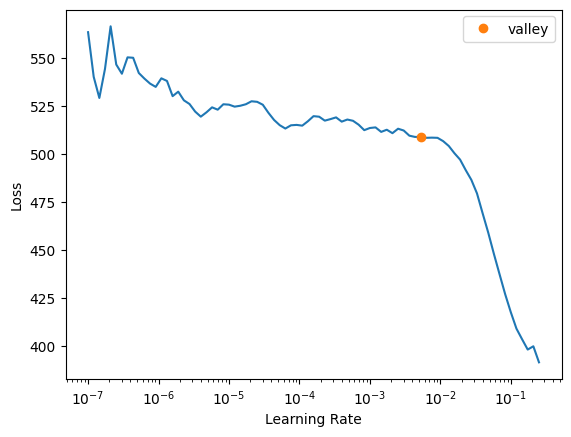

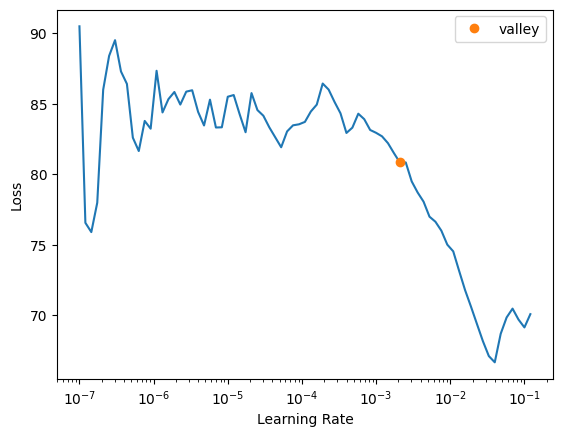

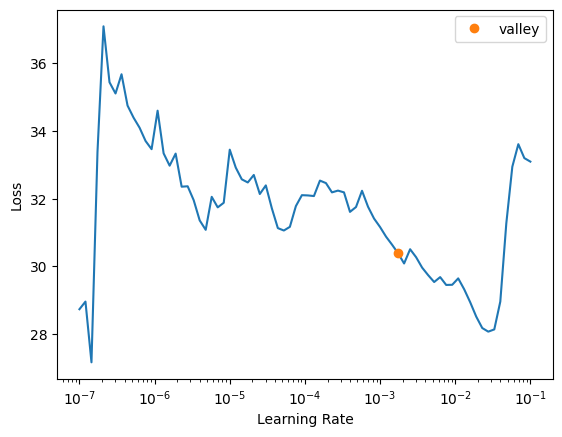

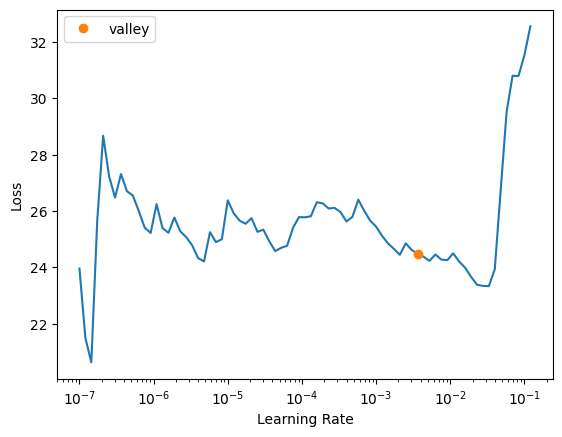

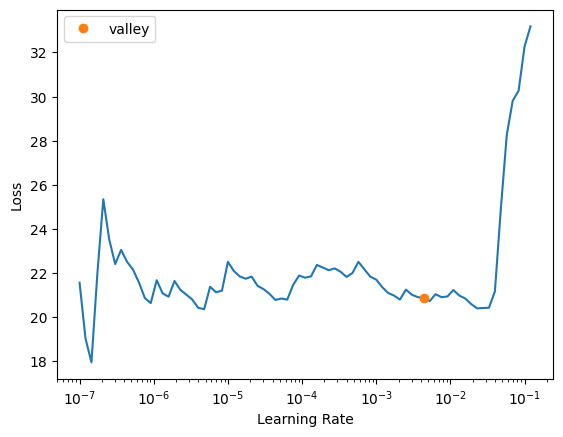

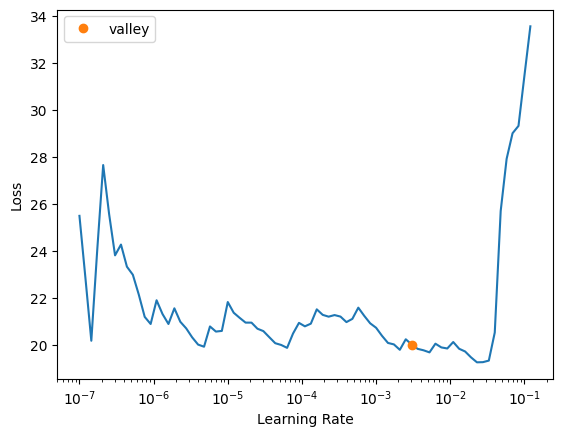

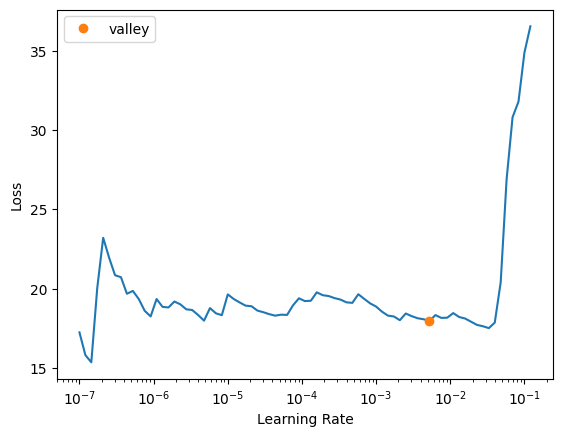

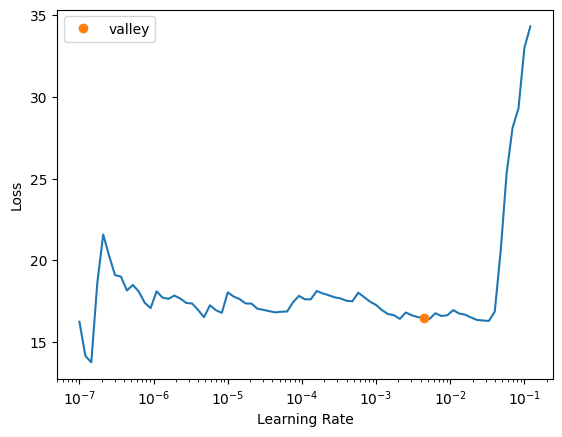

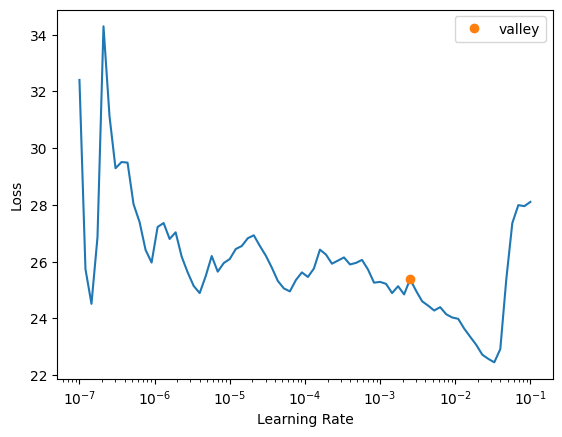

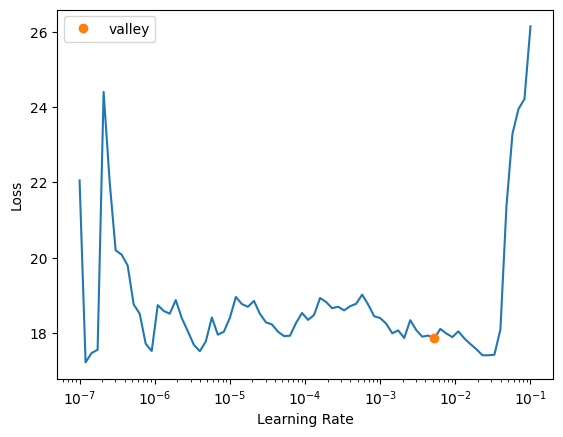

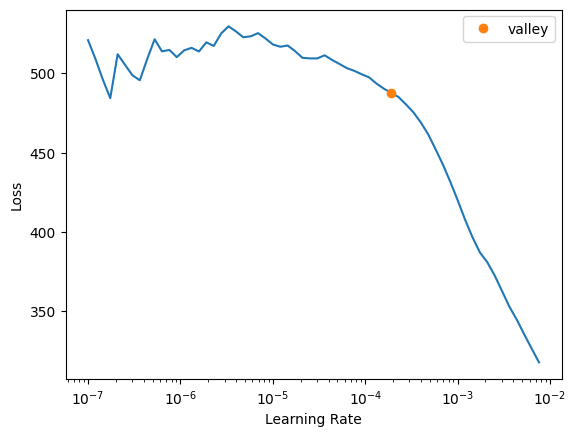

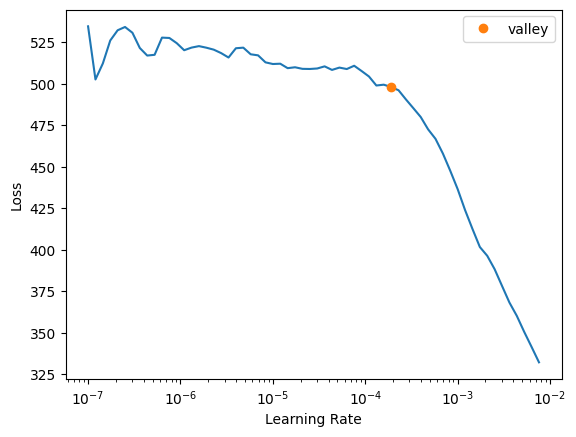

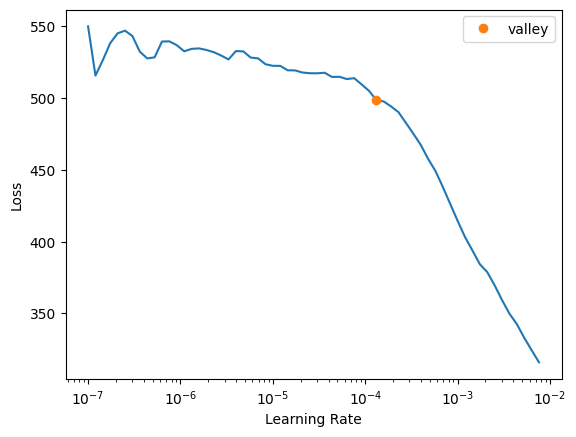

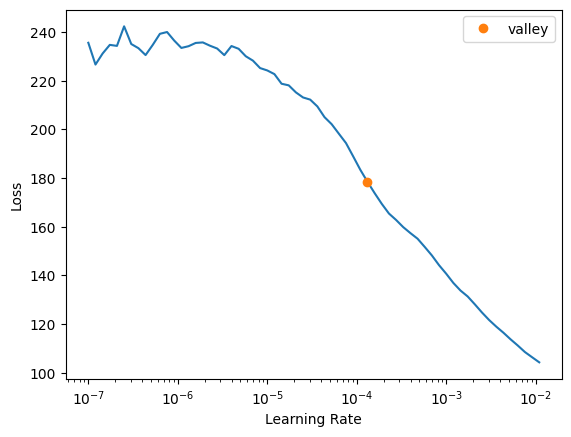

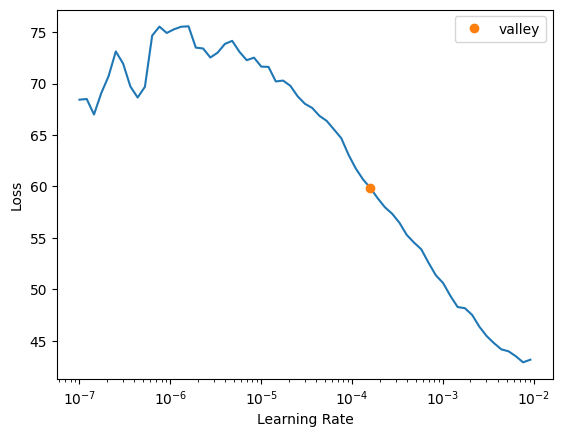

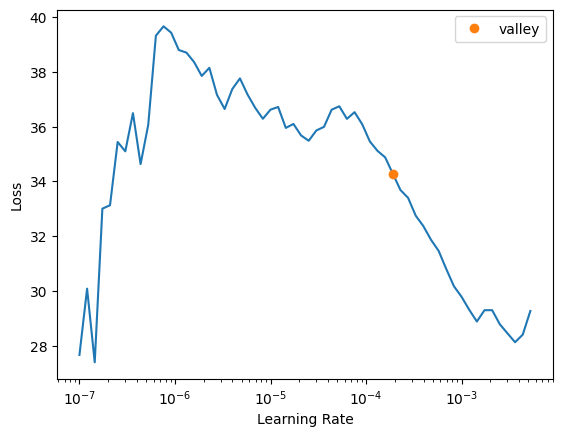

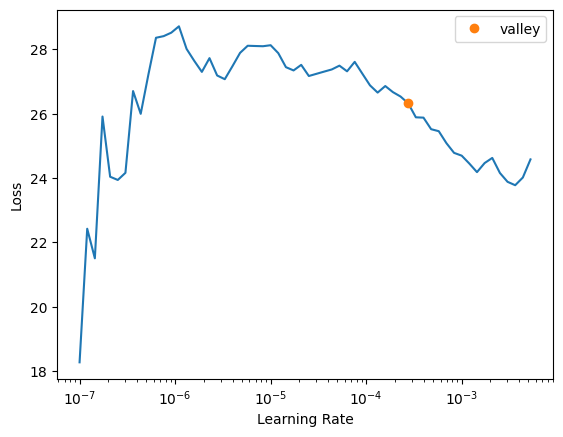

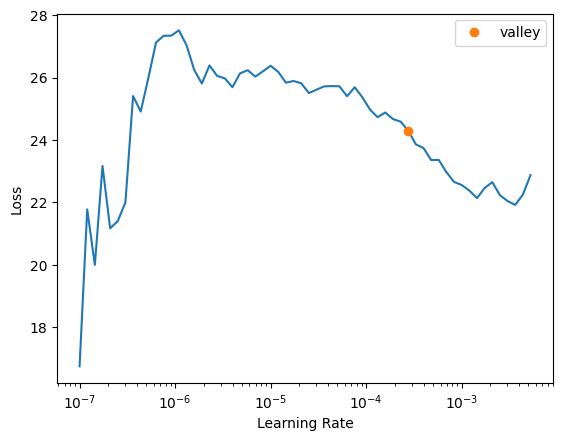

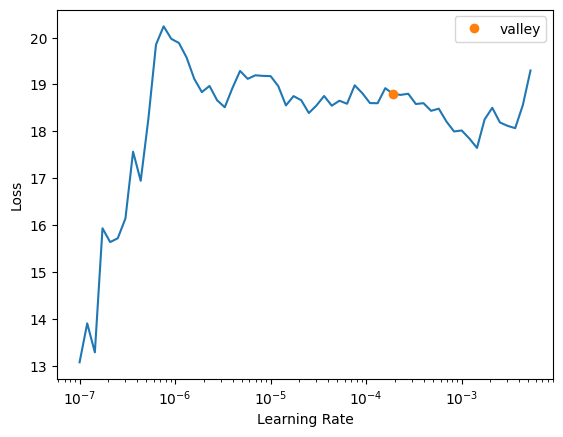

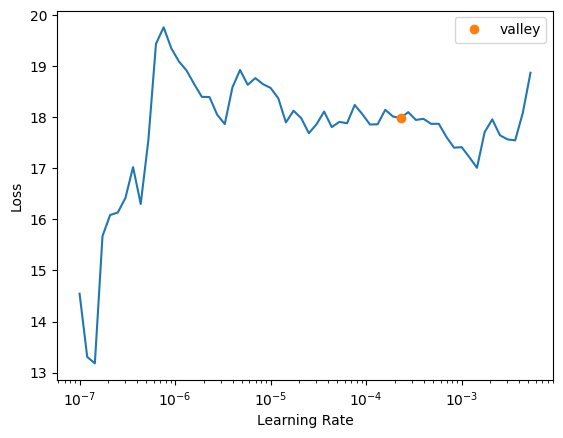

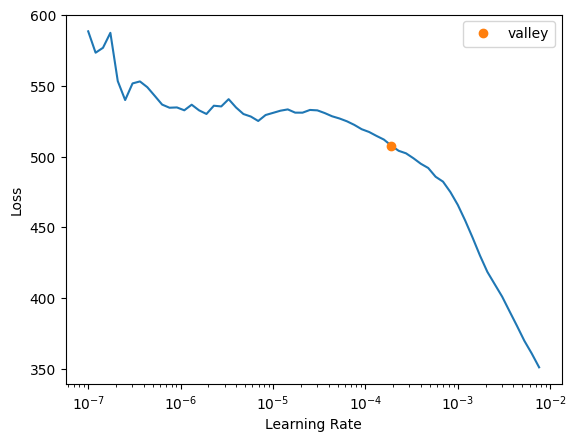

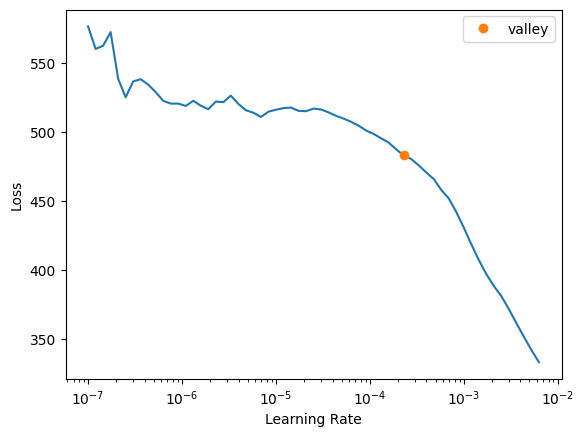

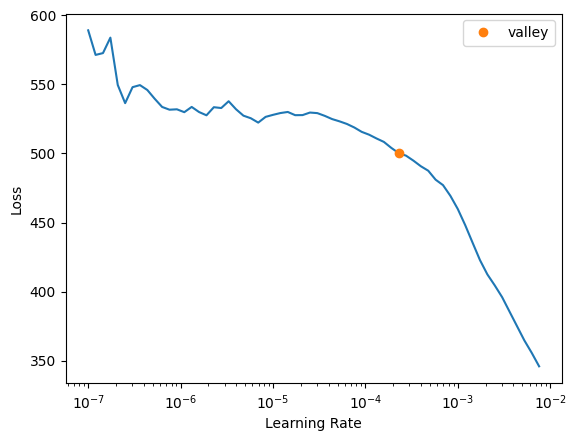

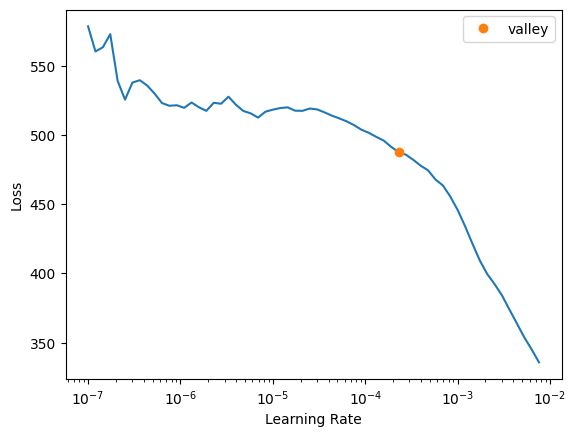

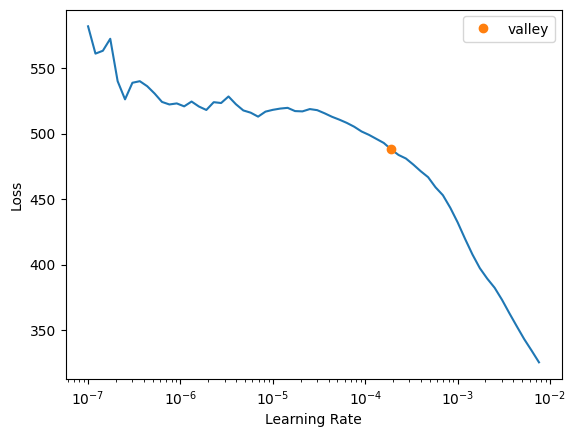

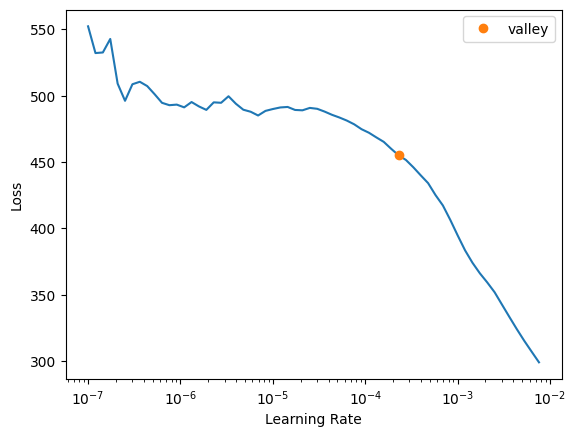

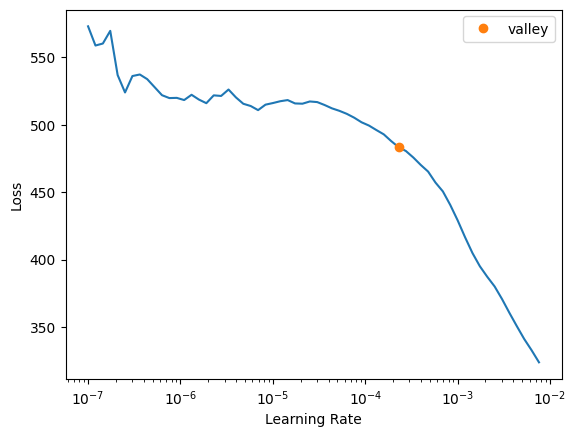

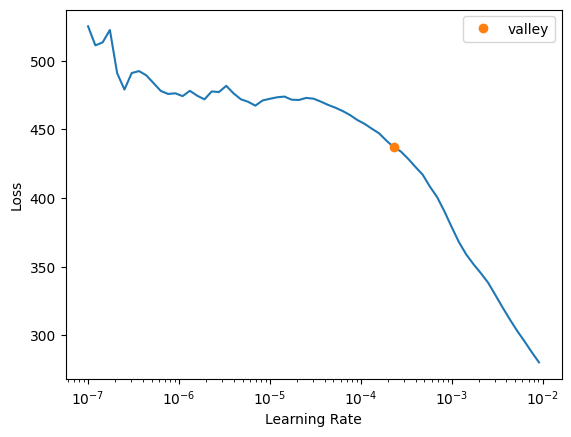

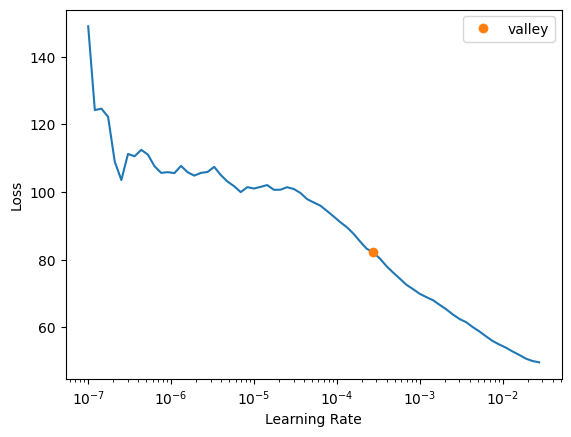

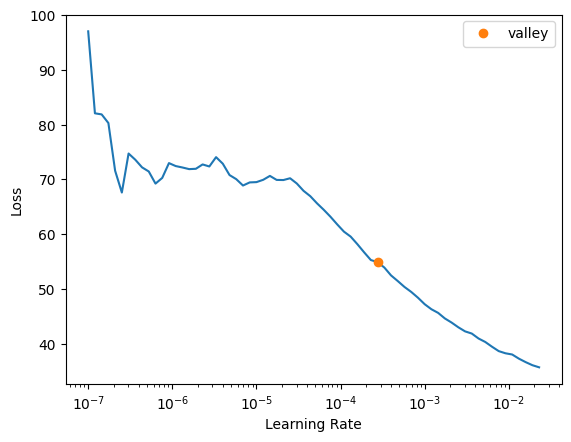

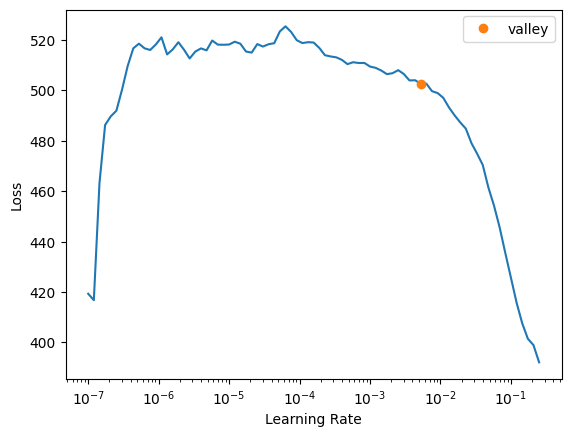

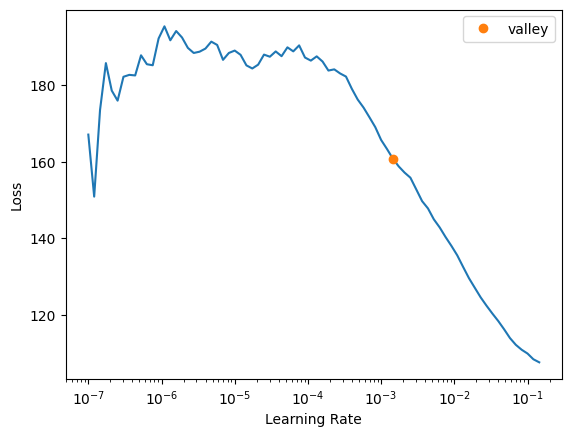

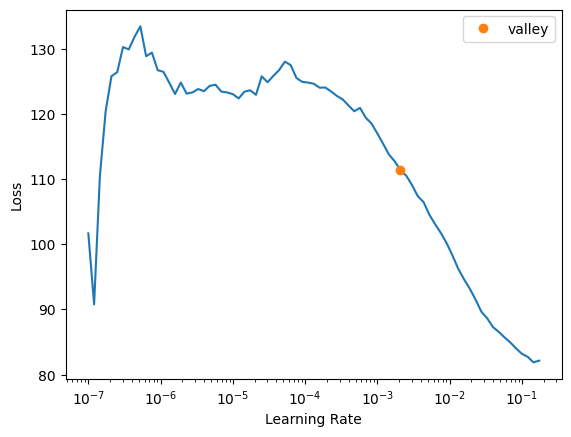

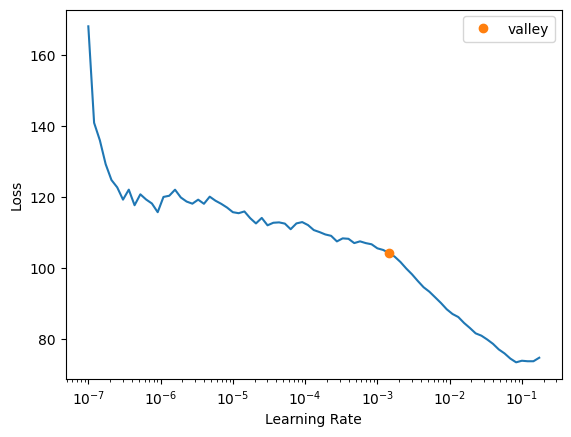

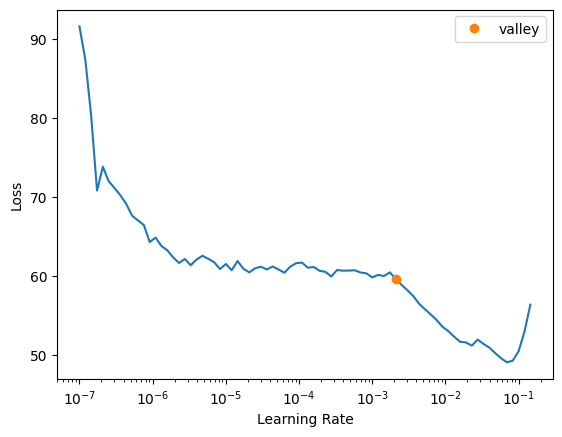

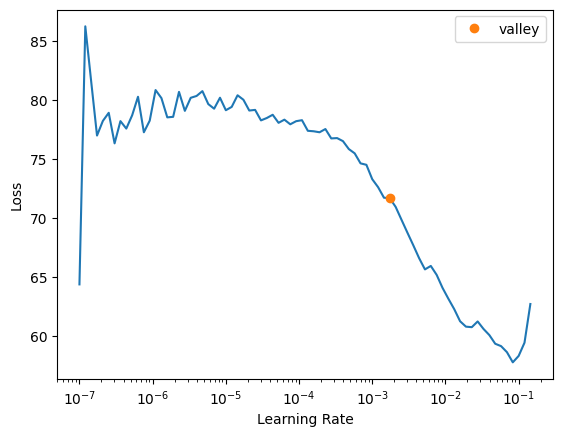

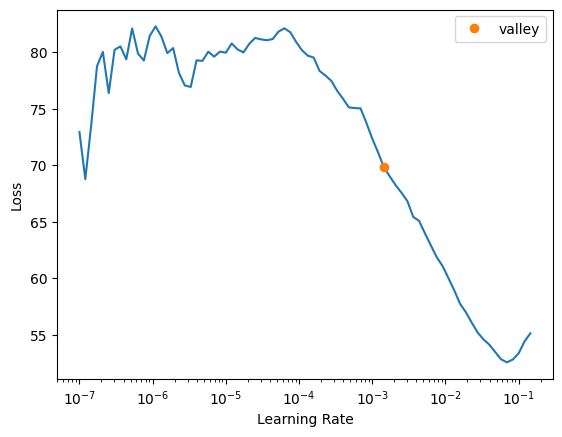

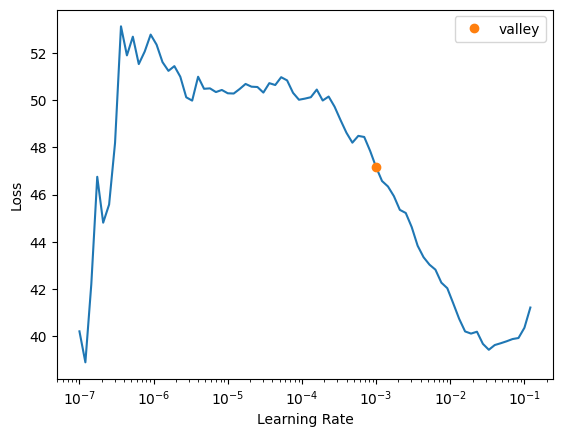

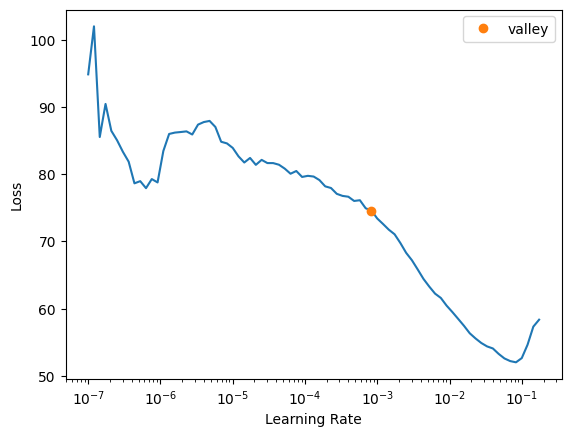

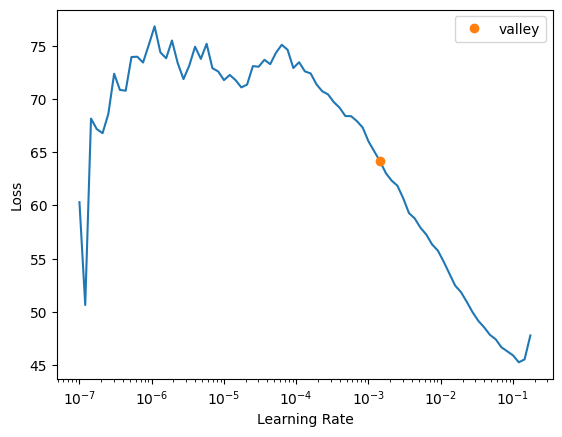

In [40]:
# Running SHADE algorithm with GD
results['SHADE-GD'] = {}
for layer in n_layers:
  utilsTFG.set_seed()
  start = time.perf_counter()
  results['SHADE-GD'][layer] = utilsTFG.SHADE_GD(copy.deepcopy(population[layer]), copy.deepcopy(fitness[layer]), max_evals, max_evals_shade, dls, mh_learners[layer], mh_learners[layer].model, task='reg')
  end = time.perf_counter()
  time_mh['SHADE-GD'][layer] = end-start

file_path = f'/notebooks/saved_models/SHADE-GD_dict_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(results['SHADE-GD'], f)

file_path = f'/notebooks/saved_models/SHADE-GD_time_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(time_mh['SHADE-GD'], f)


In [21]:
#Validation error
fitness_valid['SHADE-GD'] = {}
for layer in n_layers:
  fitness_valid['SHADE-GD'][layer] = []
  for ind in results['SHADE-GD'][layer][3]:
    fitness_valid['SHADE-GD'][layer].append(utilsTFG.err_param_valid(ind, mh_learners[layer].model, dls, task='reg'))

In [22]:
#Compare train and valid
for layer in n_layers:
  print(f"Training error of SHADE-GD for {layer} layers: {results['SHADE-GD'][layer][2]}")
  print(f"Validation error of SHADE-GD for {layer} layers: {fitness_valid['SHADE-GD'][layer]}")
  dif = np.array(fitness_valid['SHADE-GD'][layer]) - np.array(results['SHADE-GD'][layer][2])
  print(f"Difference: {dif}")
  #mejor = np.argmin(dif)
  mejor = np.argmin(fitness_valid['SHADE-GD'][layer])
  best['SHADE-GD'][layer] = results['SHADE-GD'][layer][3][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")
  print("\n")

Training error of SHADE-GD for 1 layers: [473.36053466796875, 436.02587890625, 434.20037841796875, 323.6761779785156, 39.267852783203125, 26.21971893310547, 20.162784576416016, 17.778484344482422, 17.778484344482422, 15.186634063720703, 15.186634063720703, 14.044845581054688, 14.044845581054688, 14.044845581054688, 13.97726821899414, 13.298967361450195, 12.950834274291992, 12.442526817321777, 12.442526817321777, 12.442526817321777, 12.442526817321777, 12.442526817321777]
Validation error of SHADE-GD for 1 layers: [492.4795837402344, 509.06927490234375, 508.0559997558594, 333.57342529296875, 80.40156555175781, 64.62747955322266, 77.68577575683594, 65.82130432128906, 65.82130432128906, 61.030601501464844, 61.030601501464844, 56.69140625, 56.69140625, 56.69140625, 35.75636672973633, 72.78559112548828, 61.40705871582031, 36.52949905395508, 36.52949905395508, 36.52949905395508, 36.52949905395508, 36.52949905395508]
Difference: [19.11904907 73.043396   73.85562134  9.89724731 41.13371277 38.

### SHADE-ILS-GD

deque([1, 1, 0.9730152922801368], maxlen=3)


Better model found at epoch 0 with valid_loss value: 11.984114646911621.
deque([1, 0.9730152922801368, 0.21333216763559693], maxlen=3)
deque([0.9730152922801368, 0.21333216763559693, 0.045249356197351445], maxlen=3)


Better model found at epoch 0 with valid_loss value: 10.35013198852539.
deque([0.21333216763559693, 0.045249356197351445, 0.057211551795212624], maxlen=3)
deque([0.045249356197351445, 0.057211551795212624, 0.008412218086732811], maxlen=3)


Better model found at epoch 0 with valid_loss value: 8.589963912963867.
deque([0.057211551795212624, 0.008412218086732811, 0.0], maxlen=3)
deque([0.008412218086732811, 0.0, 0.0], maxlen=3)
Reiniciado


Better model found at epoch 0 with valid_loss value: 6.836269855499268.
deque([1, 1, 0.21997157253750094], maxlen=3)
deque([1, 0.21997157253750094, 0.34759743999361054], maxlen=3)


Better model found at epoch 0 with valid_loss value: 6.135181427001953.
deque([0.21997157253750094, 0.34759743999361054, 0.018805226254701934], maxlen=3)
deque([0.34759743999361054, 0.018805226254701934, 0.0026232366833110147], maxlen=3)


Better model found at epoch 0 with valid_loss value: 7.377773284912109.
deque([0.018805226254701934, 0.0026232366833110147, 0.0995823077744477], maxlen=3)
deque([0.0026232366833110147, 0.0995823077744477, -0.03567705059152485], maxlen=3)


Better model found at epoch 0 with valid_loss value: 9.079614639282227.
deque([0.0995823077744477, -0.03567705059152485, -0.013166970983369814], maxlen=3)
deque([-0.03567705059152485, -0.013166970983369814, -0.014661996000263898], maxlen=3)
Reiniciado


Better model found at epoch 0 with valid_loss value: 11.264083862304688.
deque([1, 1, 0.19046905661158164], maxlen=3)
deque([1, 0.19046905661158164, 0.12636653898273612], maxlen=3)


Better model found at epoch 0 with valid_loss value: 10.402804374694824.
deque([0.19046905661158164, 0.12636653898273612, 0.0], maxlen=3)
deque([0.12636653898273612, 0.0, 0.024758127920181824], maxlen=3)


Better model found at epoch 0 with valid_loss value: 7.558567047119141.
deque([0.0, 0.024758127920181824, -0.025386653946043357], maxlen=3)
Reiniciado
deque([1, 1, 0.9808571031442502], maxlen=3)


Better model found at epoch 0 with valid_loss value: 11.145373344421387.
deque([1, 0.9808571031442502, -0.03359105132381795], maxlen=3)
deque([0.9808571031442502, -0.03359105132381795, -0.016727585199894306], maxlen=3)


Better model found at epoch 0 with valid_loss value: 10.36040210723877.
deque([-0.03359105132381795, -0.016727585199894306, 0.015093795537574027], maxlen=3)
Reiniciado
deque([1, 1, 0.5185932675025959], maxlen=3)


Better model found at epoch 0 with valid_loss value: 6.910977840423584.
deque([1, 0.5185932675025959, -0.02380381885924386], maxlen=3)
deque([0.5185932675025959, -0.02380381885924386, 0.09707496943032615], maxlen=3)


Better model found at epoch 0 with valid_loss value: 15.089070320129395.
deque([-0.02380381885924386, 0.09707496943032615, -0.09383697456166874], maxlen=3)
deque([0.09707496943032615, -0.09383697456166874, 0.026474434039658174], maxlen=3)


Better model found at epoch 0 with valid_loss value: 10.650511741638184.
deque([-0.09383697456166874, 0.026474434039658174, 0.09413844252096648], maxlen=3)
deque([0.026474434039658174, 0.09413844252096648, 0.0], maxlen=3)


Better model found at epoch 0 with valid_loss value: 8.42791748046875.
deque([0.09413844252096648, 0.0, 0.00754959601631934], maxlen=3)
deque([0.0, 0.00754959601631934, 0.0], maxlen=3)
Reiniciado


Better model found at epoch 0 with valid_loss value: 11.058711051940918.
deque([1, 1, 0.23174738130846226], maxlen=3)
deque([1, 0.23174738130846226, 0.18893290206196953], maxlen=3)


Better model found at epoch 0 with valid_loss value: 11.33195686340332.
deque([0.23174738130846226, 0.18893290206196953, 0.1266127523344288], maxlen=3)
deque([0.18893290206196953, 0.1266127523344288, -0.07855974532274755], maxlen=3)


Better model found at epoch 0 with valid_loss value: 9.91152286529541.
deque([0.1266127523344288, -0.07855974532274755, 0.0], maxlen=3)
deque([-0.07855974532274755, 0.0, 0.0], maxlen=3)
Reiniciado


Better model found at epoch 0 with valid_loss value: 20.915630340576172.
deque([1, 1, 0.334571585499051], maxlen=3)
deque([1, 1, 0.9767833152842029], maxlen=3)


/usr/local/lib/python3.11/dist-packages/fastai/callback/schedule.py:274: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1,1)


Better model found at epoch 0 with valid_loss value: 6.515783309936523.
deque([1, 0.9767833152842029, 0.2491463578110045], maxlen=3)
deque([0.9767833152842029, 0.2491463578110045, 0.021181447785222764], maxlen=3)


Better model found at epoch 0 with valid_loss value: 10.364697456359863.
deque([0.2491463578110045, 0.021181447785222764, -0.09786987783388974], maxlen=3)
deque([0.021181447785222764, -0.09786987783388974, 0.15116691883415603], maxlen=3)


Better model found at epoch 0 with valid_loss value: 7.186113357543945.
deque([-0.09786987783388974, 0.15116691883415603, -0.1780879211570469], maxlen=3)
deque([0.15116691883415603, -0.1780879211570469, 0.15279079792076336], maxlen=3)


Better model found at epoch 0 with valid_loss value: 5.422667980194092.
deque([-0.1780879211570469, 0.15279079792076336, -0.1803460084543243], maxlen=3)
deque([0.15279079792076336, -0.1803460084543243, 0.0], maxlen=3)


Better model found at epoch 0 with valid_loss value: 6.596920490264893.
deque([-0.1803460084543243, 0.0, 0.2189738685856675], maxlen=3)
deque([0.0, 0.2189738685856675, -0.07630680827324703], maxlen=3)


Better model found at epoch 0 with valid_loss value: 15.20930004119873.
deque([0.2189738685856675, -0.07630680827324703, 0.11599238580969937], maxlen=3)
deque([-0.07630680827324703, 0.11599238580969937, -0.13121197594654388], maxlen=3)


Better model found at epoch 0 with valid_loss value: 9.12331485748291.
deque([0.11599238580969937, -0.13121197594654388, 0.04742425654889531], maxlen=3)
deque([-0.13121197594654388, 0.04742425654889531, -0.049785286760589846], maxlen=3)
Reiniciado


Better model found at epoch 0 with valid_loss value: 52.73685836791992.
deque([1, 1, 0.7708982265135391], maxlen=3)
deque([1, 0.7708982265135391, 0.1470903813053302], maxlen=3)


Better model found at epoch 0 with valid_loss value: 10.322741508483887.
deque([0.7708982265135391, 0.1470903813053302, -0.007558402522911751], maxlen=3)
deque([0.1470903813053302, -0.007558402522911751, -0.10223309905020989], maxlen=3)


Better model found at epoch 0 with valid_loss value: 9.963105201721191.
deque([-0.007558402522911751, -0.10223309905020989, 0.08651191198788144], maxlen=3)
deque([1, 1, 0.9127511691740192], maxlen=3)


Better model found at epoch 0 with valid_loss value: 466.4326477050781.
deque([1, 0.9127511691740192, 0.6494941151175201], maxlen=3)
deque([0.9127511691740192, 0.6494941151175201, 0.20315908840888405], maxlen=3)


Better model found at epoch 0 with valid_loss value: 5.272227764129639.
deque([0.6494941151175201, 0.20315908840888405, -0.5155595891892713], maxlen=3)
deque([0.20315908840888405, -0.5155595891892713, 0.12501352566119223], maxlen=3)


Better model found at epoch 0 with valid_loss value: 20.31916046142578.
deque([-0.5155595891892713, 0.12501352566119223, 0.16350505768792056], maxlen=3)
deque([0.12501352566119223, 0.16350505768792056, 0.0], maxlen=3)


Better model found at epoch 0 with valid_loss value: 11.493690490722656.
deque([0.16350505768792056, 0.0, -0.04315350366406818], maxlen=3)
deque([0.0, -0.04315350366406818, 0.15780554503995398], maxlen=3)


Better model found at epoch 0 with valid_loss value: 7.847774982452393.
deque([-0.04315350366406818, 0.15780554503995398, 0.07789153068245253], maxlen=3)
deque([0.15780554503995398, 0.07789153068245253, 0.18945186736413272], maxlen=3)


Better model found at epoch 0 with valid_loss value: 7.430076599121094.
deque([0.07789153068245253, 0.18945186736413272, 0.0], maxlen=3)
deque([0.18945186736413272, 0.0, -0.2156235036239778], maxlen=3)


Better model found at epoch 0 with valid_loss value: 8.005078315734863.
deque([0.0, -0.2156235036239778, 0.09431987203575455], maxlen=3)
deque([-0.2156235036239778, 0.09431987203575455, 0.0], maxlen=3)


Better model found at epoch 0 with valid_loss value: 12.960980415344238.
deque([0.09431987203575455, 0.0, -0.02649438636976305], maxlen=3)
deque([0.0, -0.02649438636976305, 0.018479772493988352], maxlen=3)
Reiniciado


Better model found at epoch 0 with valid_loss value: 43.66469955444336.
deque([1, 1, 0.6586548611973259], maxlen=3)
deque([1, 0.6586548611973259, 0.3711770222415072], maxlen=3)


Better model found at epoch 0 with valid_loss value: 7.726858139038086.
deque([0.6586548611973259, 0.3711770222415072, -0.2862569724694263], maxlen=3)


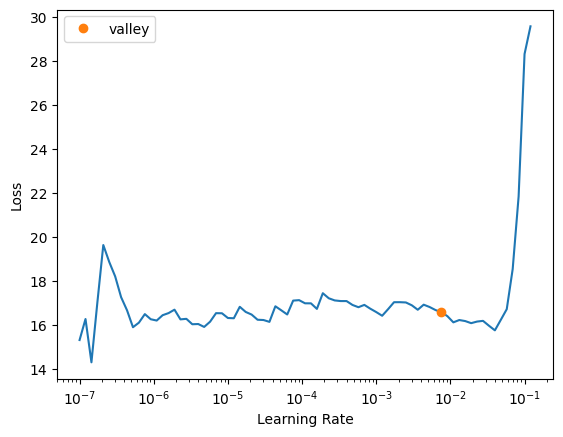

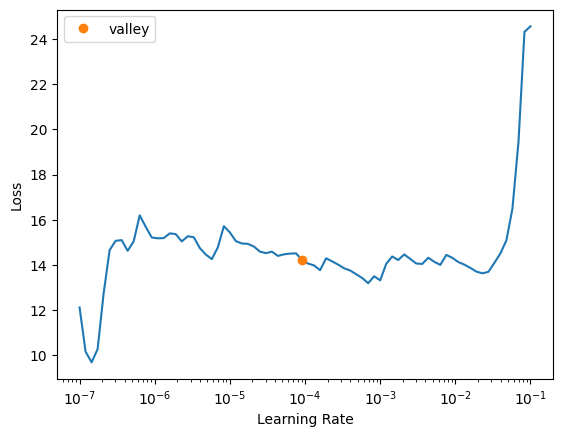

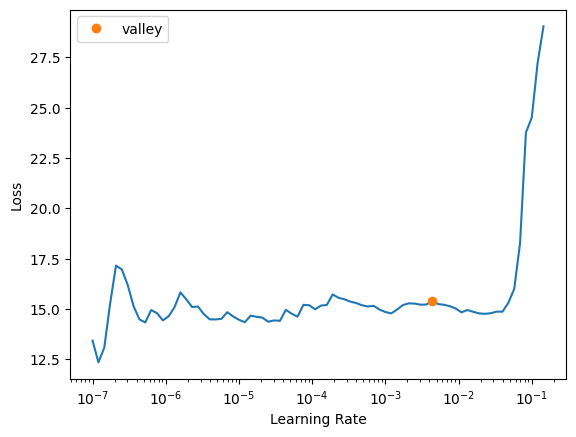

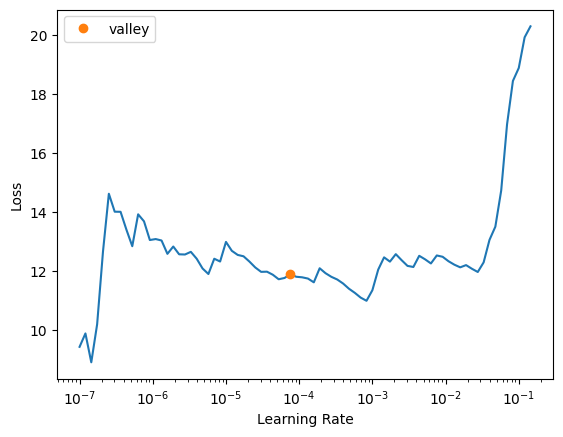

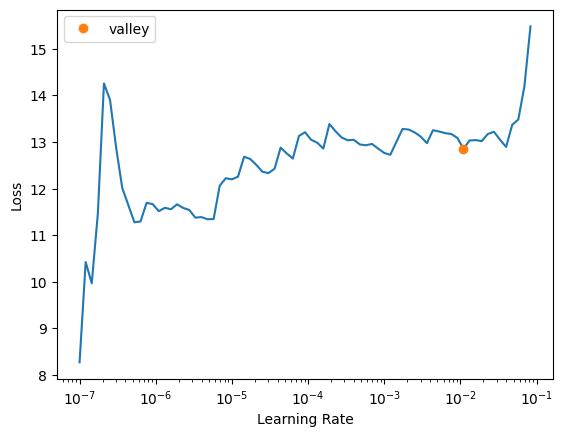

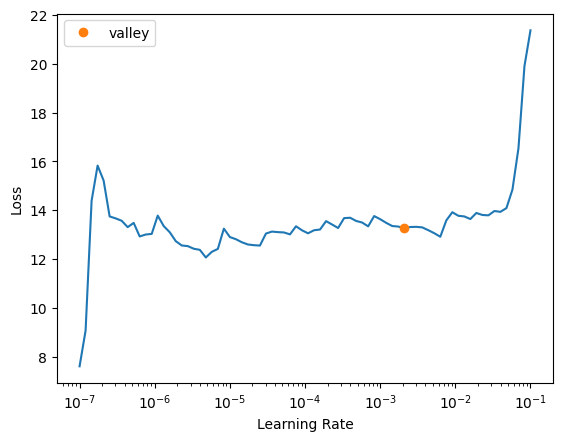

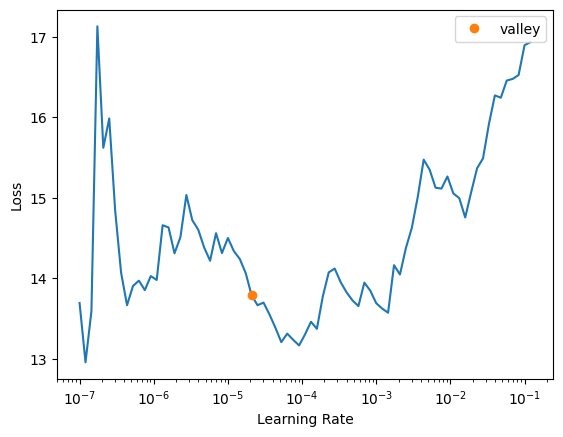

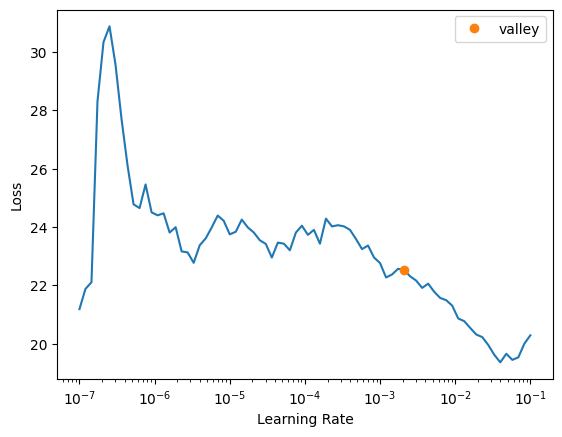

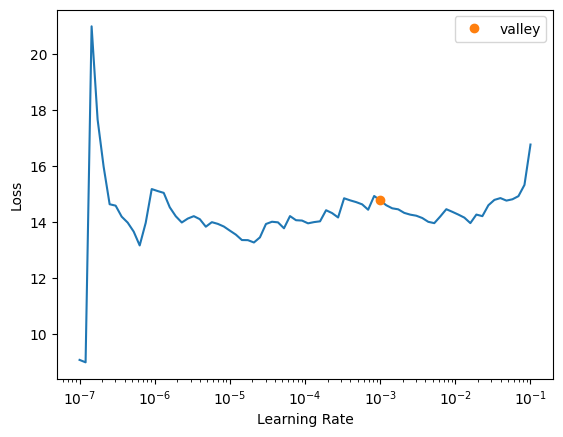

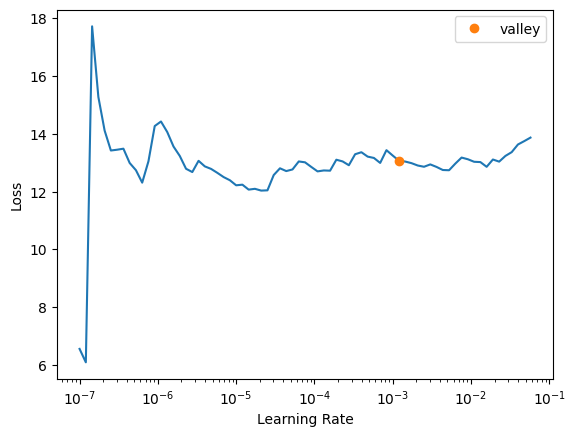

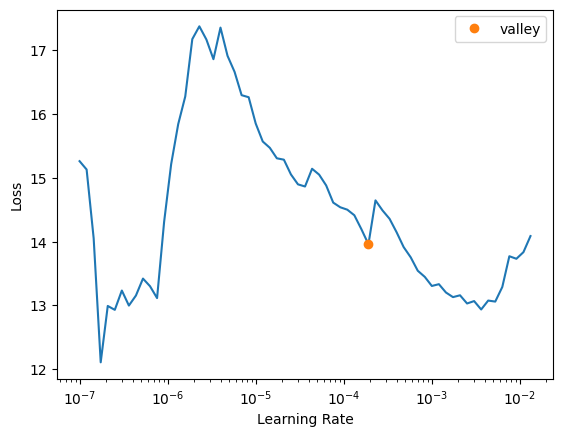

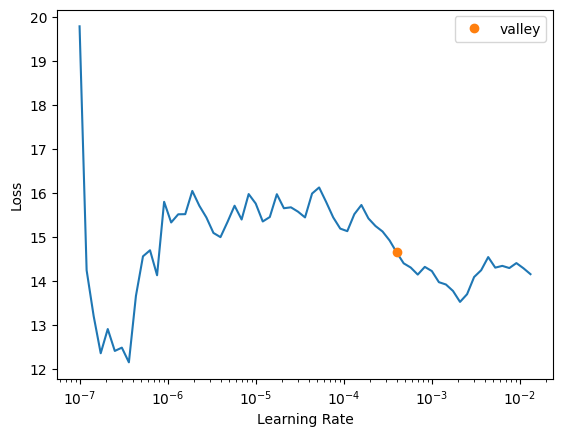

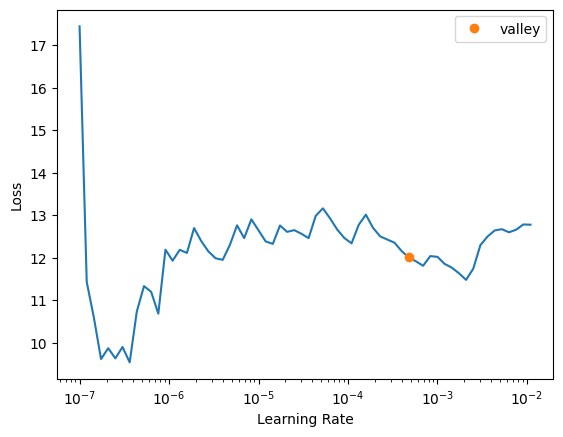

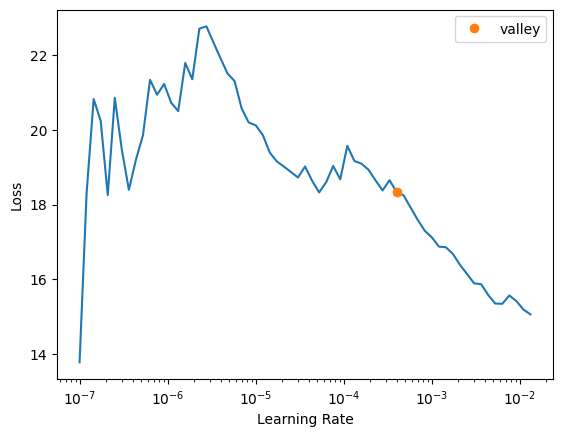

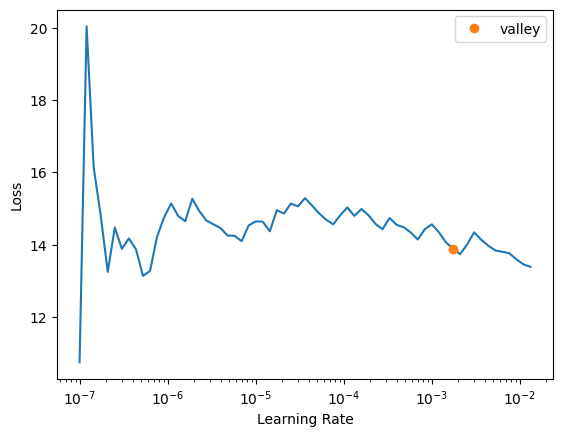

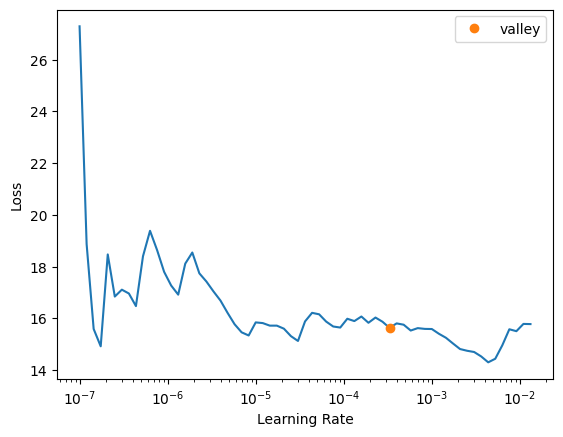

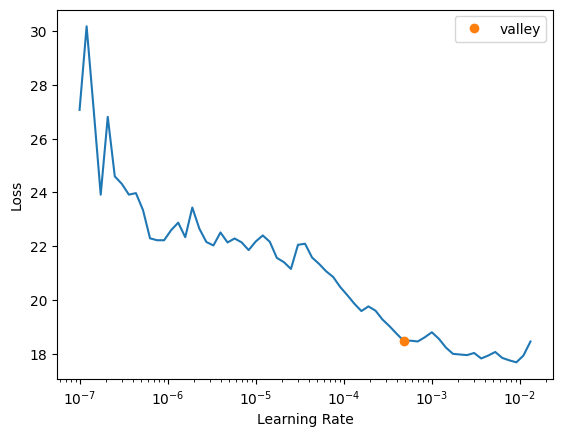

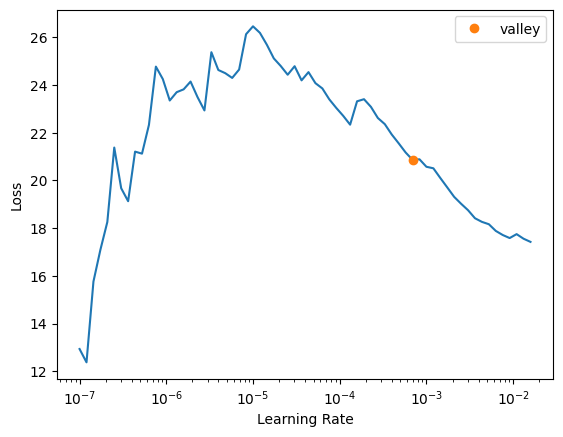

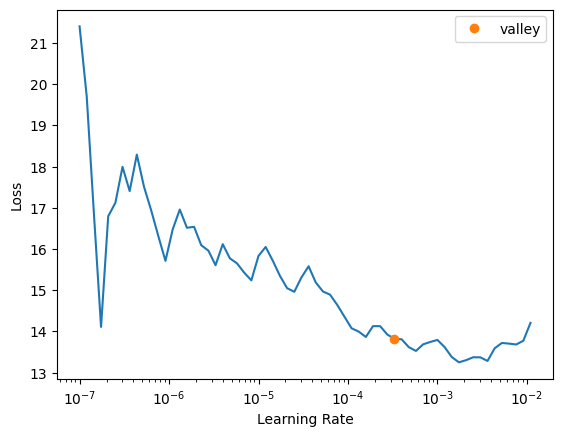

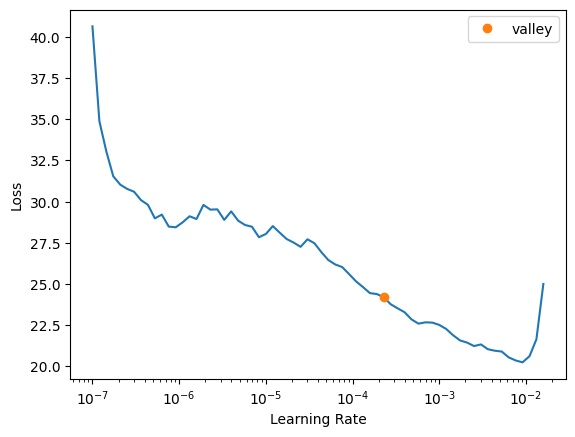

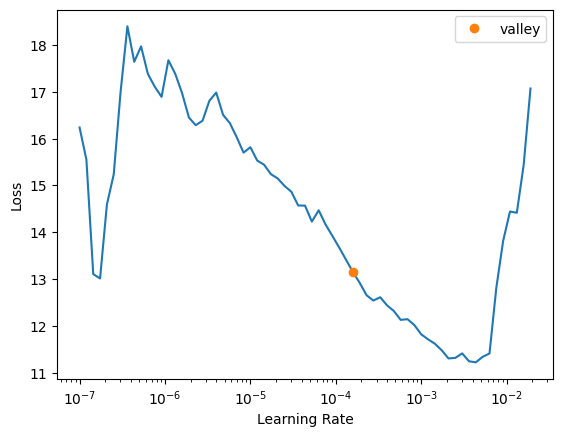

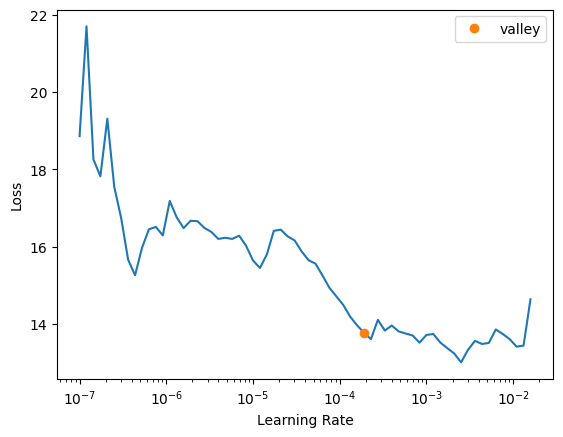

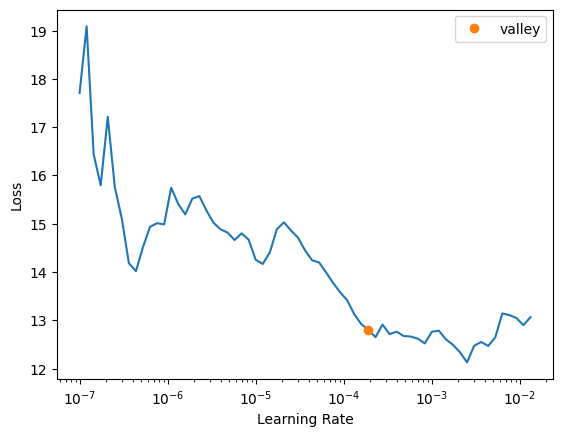

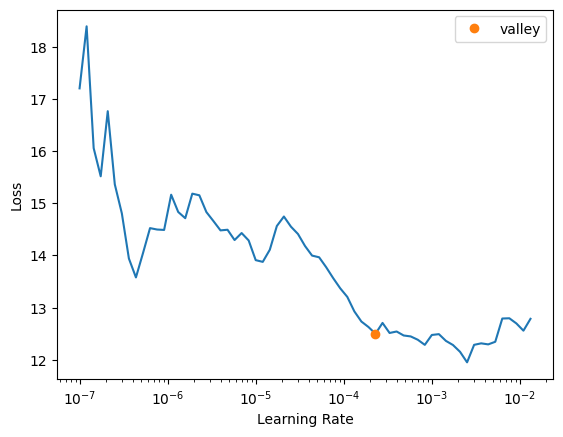

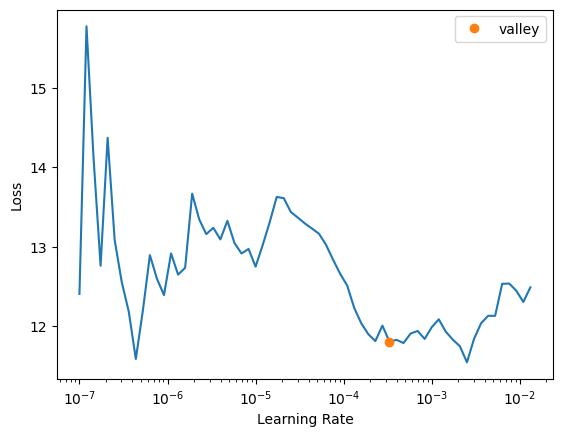

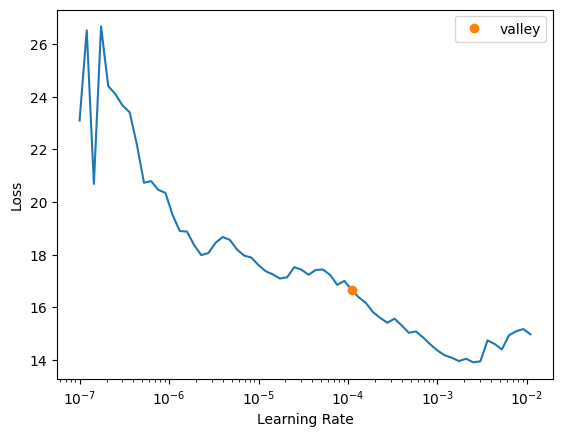

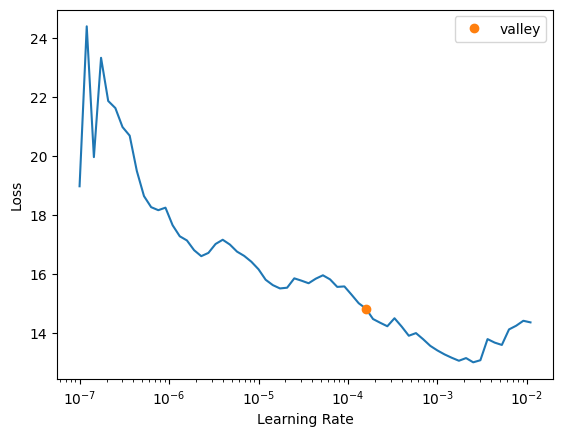

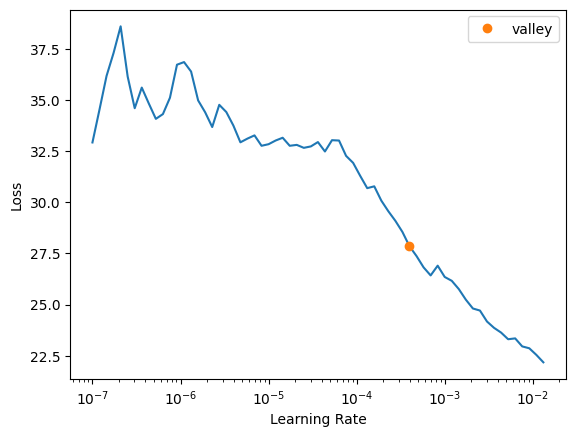

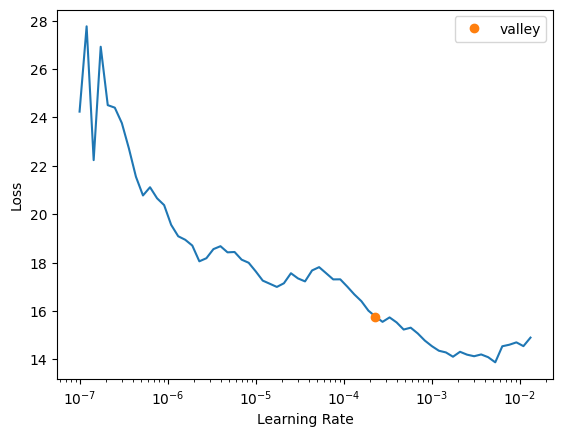

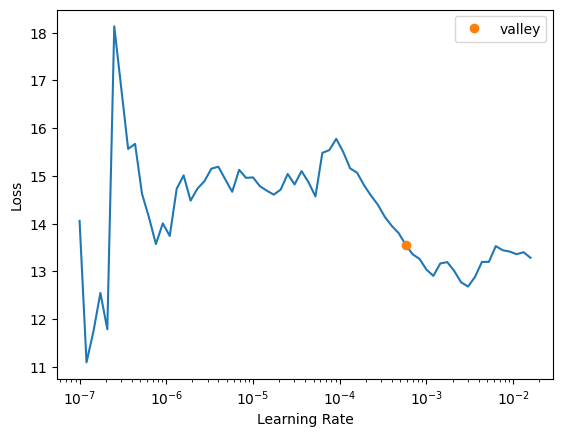

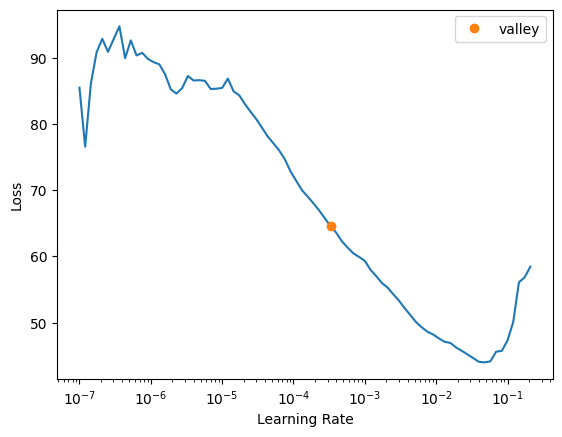

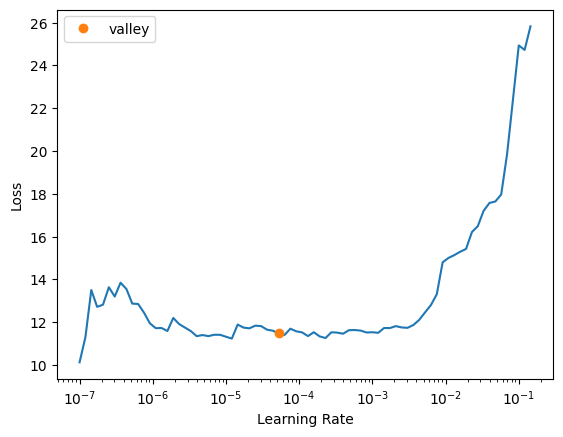

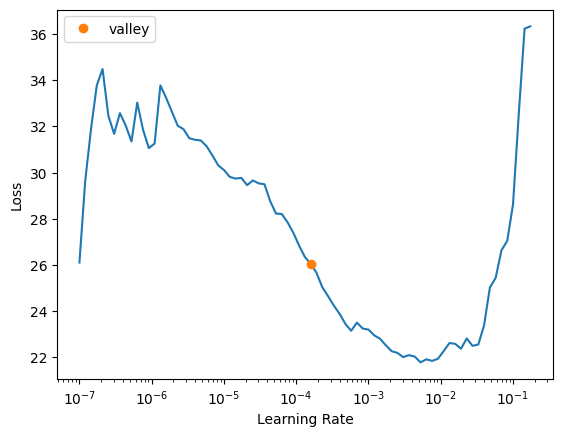

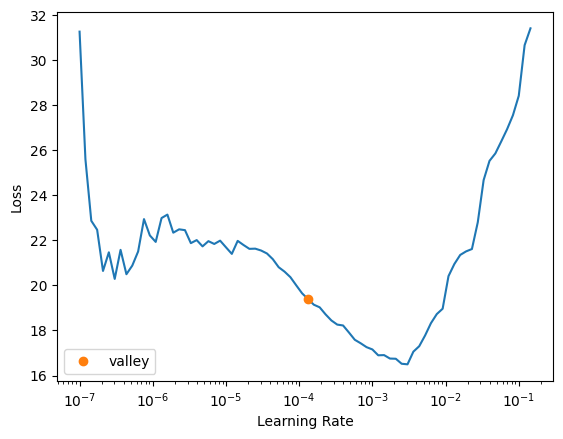

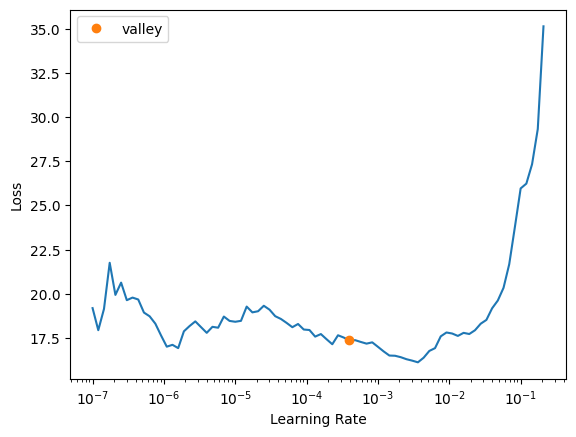

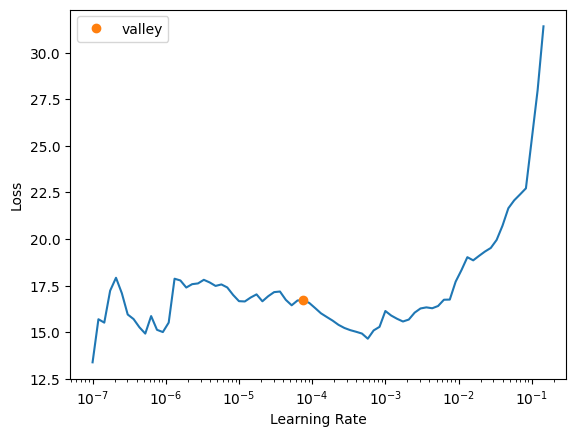

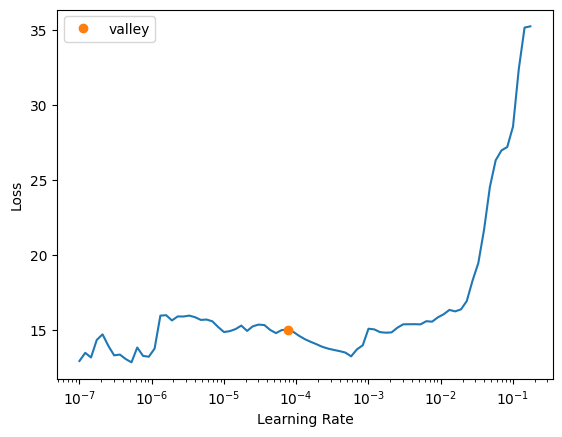

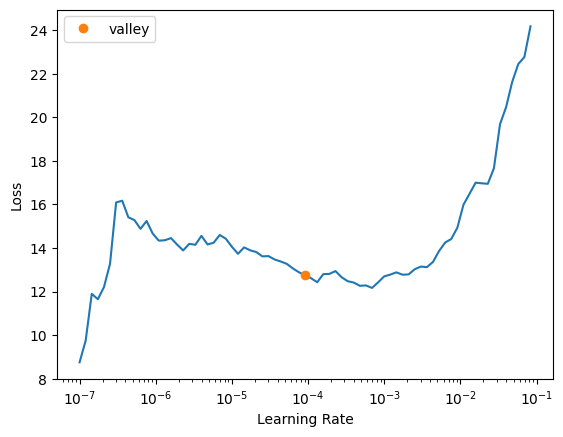

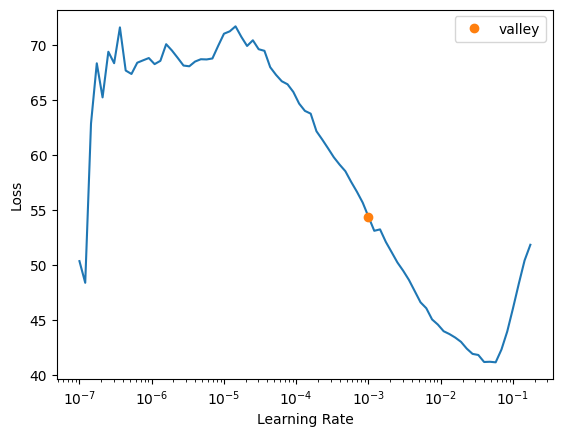

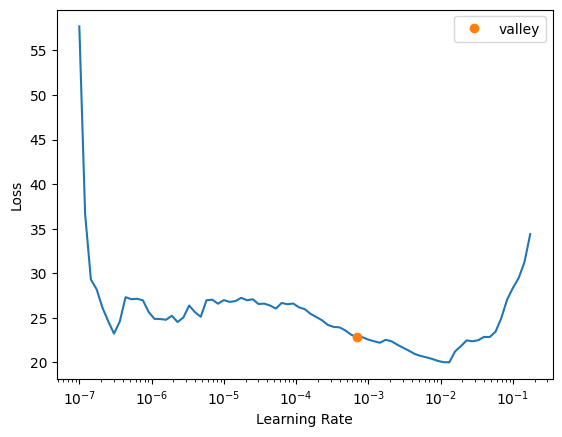

In [41]:
# Working ???
results['SHADE-ILS-GD'] = {}
for layer in n_layers:
  utilsTFG.set_seed()
  start = time.perf_counter()
  results['SHADE-ILS-GD'][layer] = utilsTFG.SHADE_ILS_GD(copy.deepcopy(population[layer]), copy.deepcopy(fitness[layer]),  max_evals, max_evals_shade, dls, mh_learners[layer], mh_learners[layer].model, max_ls=max_ls, task='reg')
  end = time.perf_counter()
  time_mh['SHADE-ILS-GD'][layer] = end-start

file_path = f'/notebooks/saved_models/SHADE-ILS-GD_dict_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(results['SHADE-ILS-GD'], f)

file_path = f'/notebooks/saved_models/SHADE-ILS-GD_time_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(time_mh['SHADE-ILS-GD'], f)


In [23]:
#Validation error
fitness_valid['SHADE-ILS-GD'] = {}
for layer in n_layers:
  fitness_valid['SHADE-ILS-GD'][layer] = []
  for ind in results['SHADE-ILS-GD'][layer][3]:
    fitness_valid['SHADE-ILS-GD'][layer].append(utilsTFG.err_param_valid(ind, mh_learners[layer].model, dls, task='reg'))

In [24]:
#Compare train and valid
for layer in n_layers:
  print(f"Training error of SHADE-ILS-GD for {layer} layers: {results['SHADE-ILS-GD'][layer][2]}")
  print(f"Validation error of SHADE-ILS-GD for {layer} layers: {fitness_valid['SHADE-ILS-GD'][layer]}")
  dif = np.array(fitness_valid['SHADE-ILS-GD'][layer]) - np.array(results['SHADE-ILS-GD'][layer][2])
  print(f"Difference: {dif}")
  mejor = np.argmin(fitness_valid['SHADE-ILS-GD'][layer])
  best['SHADE-ILS-GD'][layer] = results['SHADE-ILS-GD'][layer][3][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")
  print("\n")

Training error of SHADE-ILS-GD for 1 layers: [473.36053466796875, 12.7734956741333, 10.048498153686523, 9.593810081481934, 9.044933319091797, 8.96884536743164, 8.96884536743164, 8.96884536743164, 8.96884536743164, 8.96884536743164, 8.927665710449219, 8.90424633026123, 8.01754093170166, 8.01754093170166, 8.01754093170166, 8.01754093170166, 8.01754093170166, 8.01754093170166, 8.01754093170166, 8.01754093170166, 8.01754093170166]
Validation error of SHADE-ILS-GD for 1 layers: [492.4795837402344, 14.905580520629883, 11.837852478027344, 16.03007698059082, 11.014784812927246, 10.492534637451172, 10.492534637451172, 10.492534637451172, 10.492534637451172, 10.492534637451172, 6.8601393699646, 10.55527400970459, 9.529510498046875, 9.529510498046875, 9.529510498046875, 9.529510498046875, 9.529510498046875, 9.529510498046875, 9.529510498046875, 9.529510498046875, 9.529510498046875]
Difference: [19.11904907  2.13208485  1.78935432  6.4362669   1.96985149  1.52368927
  1.52368927  1.52368927  1.523

### Save or load

In [72]:
#Save the mh results
file_path = f'/notebooks/saved_models/mh_dict_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(results, f)

In [65]:
#Load the trained mh results
#file_path = f'/notebooks/saved_models/mh_dict_{dataset}.pkl'
#with open(file_path, 'rb') as f:
#    results = pickle.load(f)

### Comparison between MH

In [29]:
#Saving training loss for better manipulation
training = {}
for mh in algs:
  training[mh] = {}
for layer in n_layers:
  training['SHADE'][layer] = results['SHADE'][layer][6]
  training['SHADE-ILS'][layer] = results['SHADE-ILS'][layer][2]
  training['SHADE-GD'][layer] = results['SHADE-GD'][layer][2]
  training['SHADE-ILS-GD'][layer] = results['SHADE-ILS-GD'][layer][2]

In [30]:
#Calculate r2sq
r2sq = {}
#f1score = {}
for mh in algs:
  #f1score[mh] = {}
  r2sq[mh] = {}
  for layer in n_layers:
    #1score[mh][layer] = []
    r2sq[mh][layer] = []
    ind = 5 if mh == 'SHADE' else 3
    start = time.perf_counter()
    for model in results[mh][layer][ind]:
      utilsTFG.set_params_to_model(model, mh_learners[layer].model)
      mh_learners[layer].model.eval()
      mh_learners[layer].eval()
      preds, targs = mh_learners[layer].get_preds(dl=dls.valid)
      targs = targs.long().squeeze()

      # Calculate balanced_accuracy
      r2sq[mh][layer].append(utilsTFG.adjusted_r2_score(preds, targs))

      # Calculate F1-Score
      #f1score[mh][layer].append(utilsTFG.f1_score_func(preds, targs))
    end = time.perf_counter()
    #time_full_mh[mh][layer]+= end-start

<Figure size 1200x600 with 0 Axes>

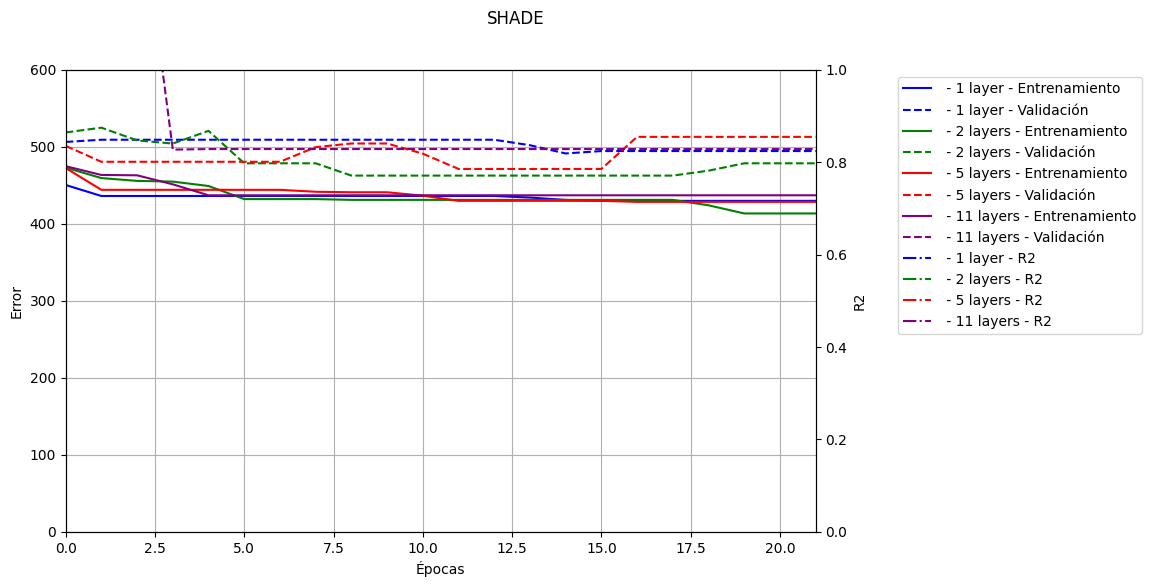

<Figure size 1200x600 with 0 Axes>

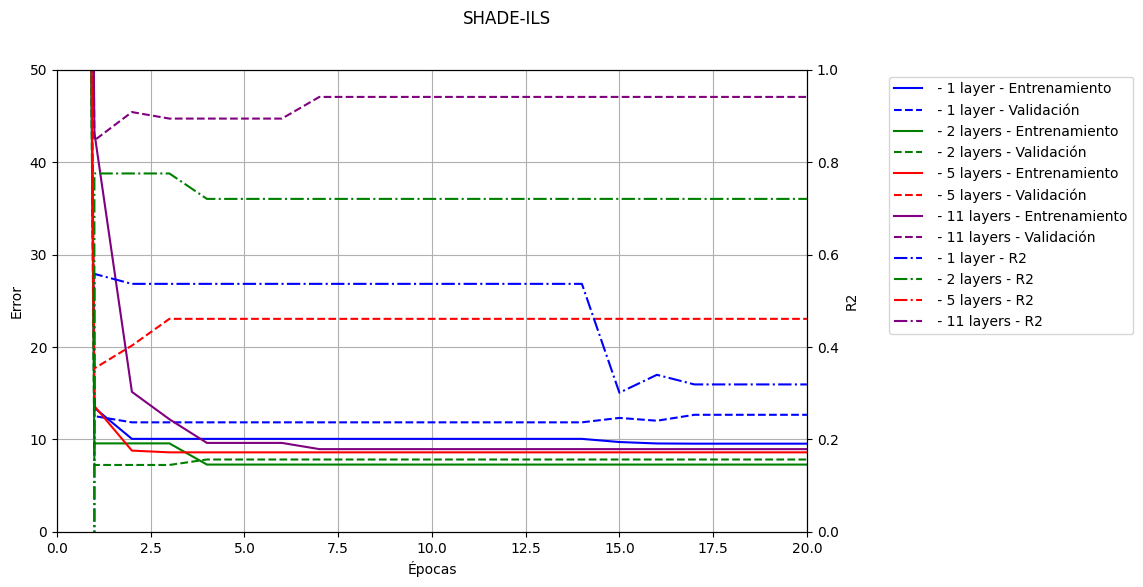

<Figure size 1200x600 with 0 Axes>

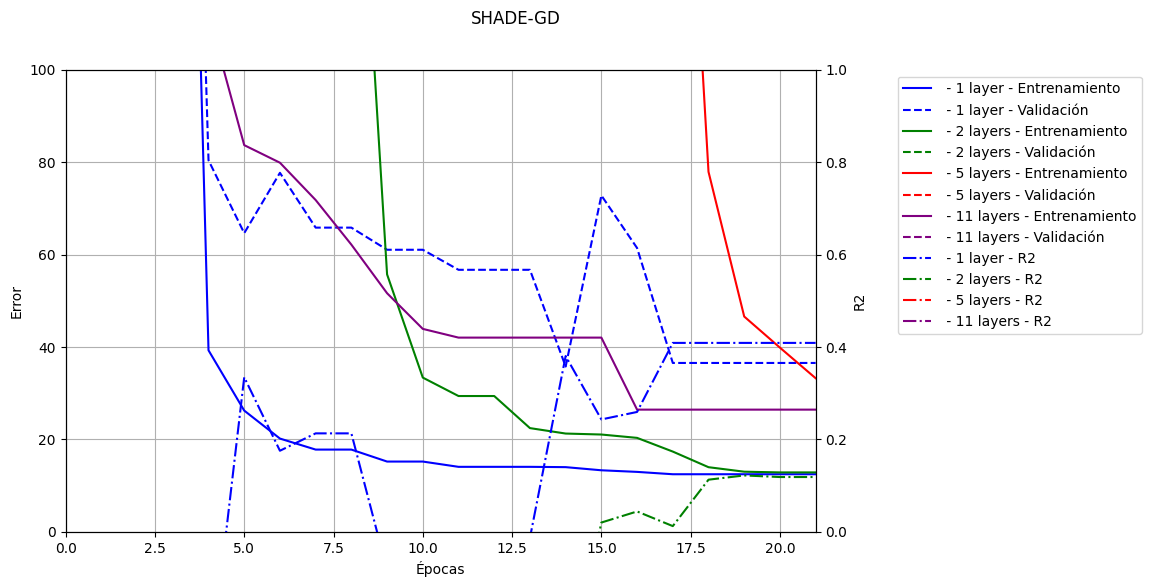

<Figure size 1200x600 with 0 Axes>

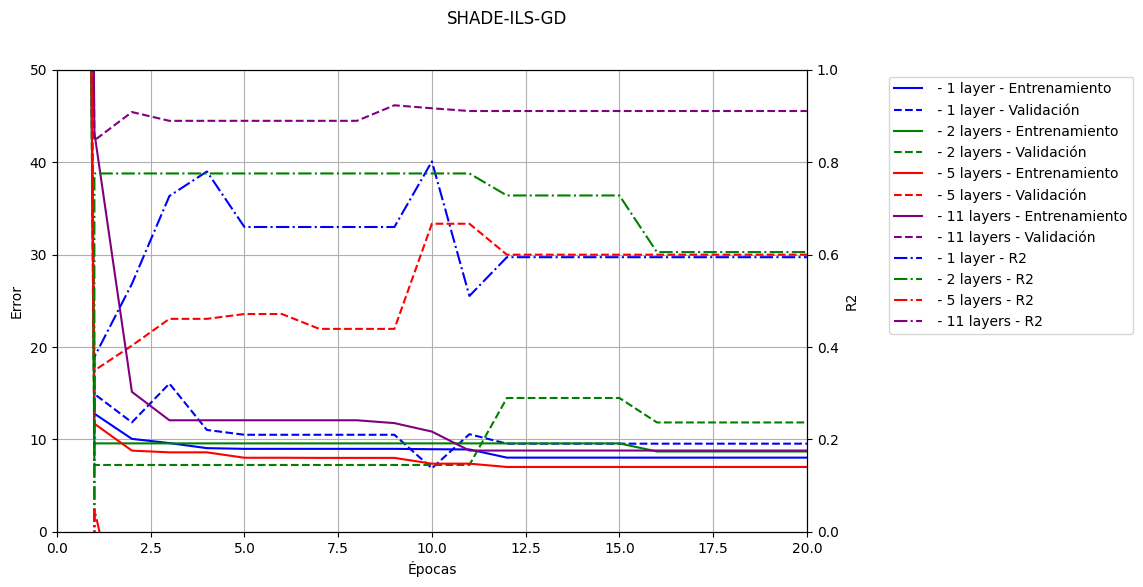

In [31]:
#Comparing the different layers version of the same MH
names= ['1 layer', '2 layers', '5 layers', '11 layers']
for alg in algs:
  if alg=='SHADE':
    li = 600 
  elif alg=='SHADE-GD':
    li = 100
  else:
    li = 50
  utilsTFG.plot_mh_mlp_training(training[alg], fitness_valid[alg], r2sq[alg], lim=li, layers = n_layers, names=names, title=f'{alg}', metric=['R2'])

<Figure size 1200x600 with 0 Axes>

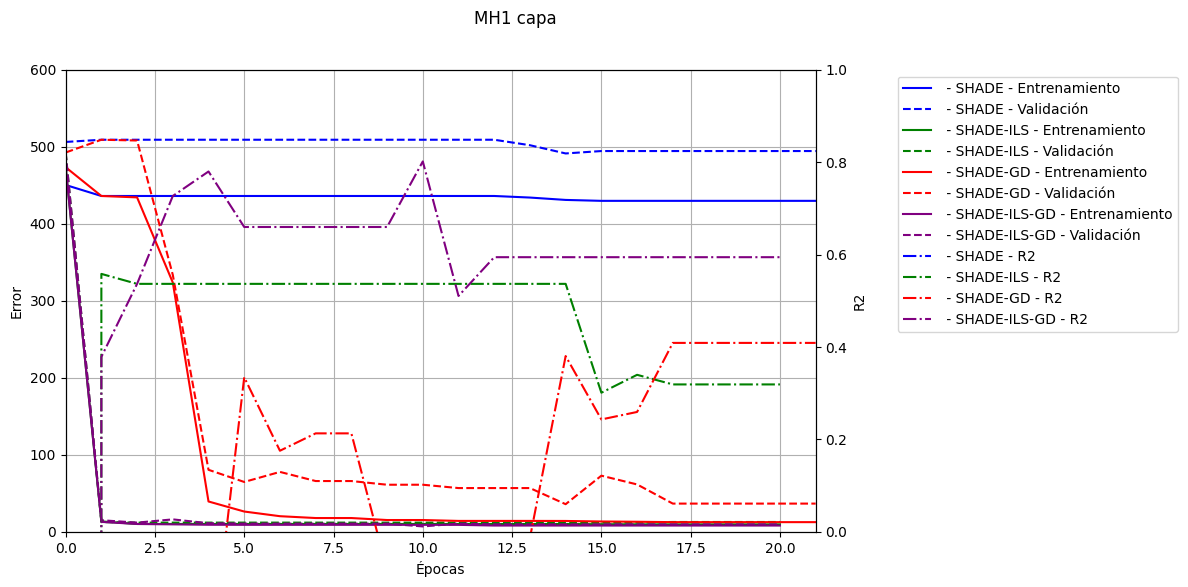

<Figure size 1200x600 with 0 Axes>

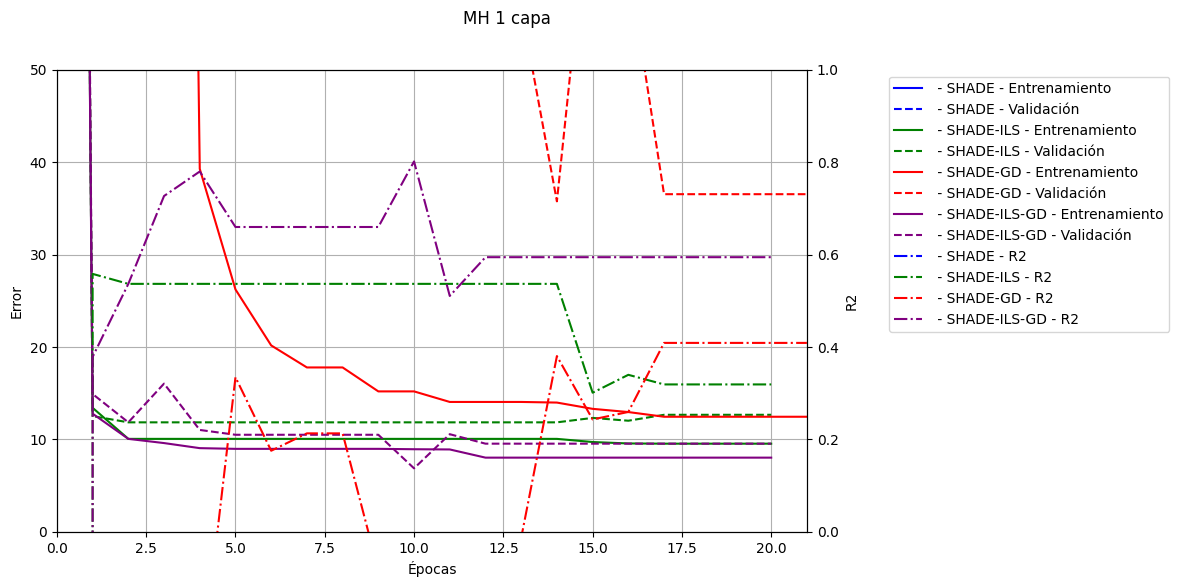

<Figure size 1200x600 with 0 Axes>

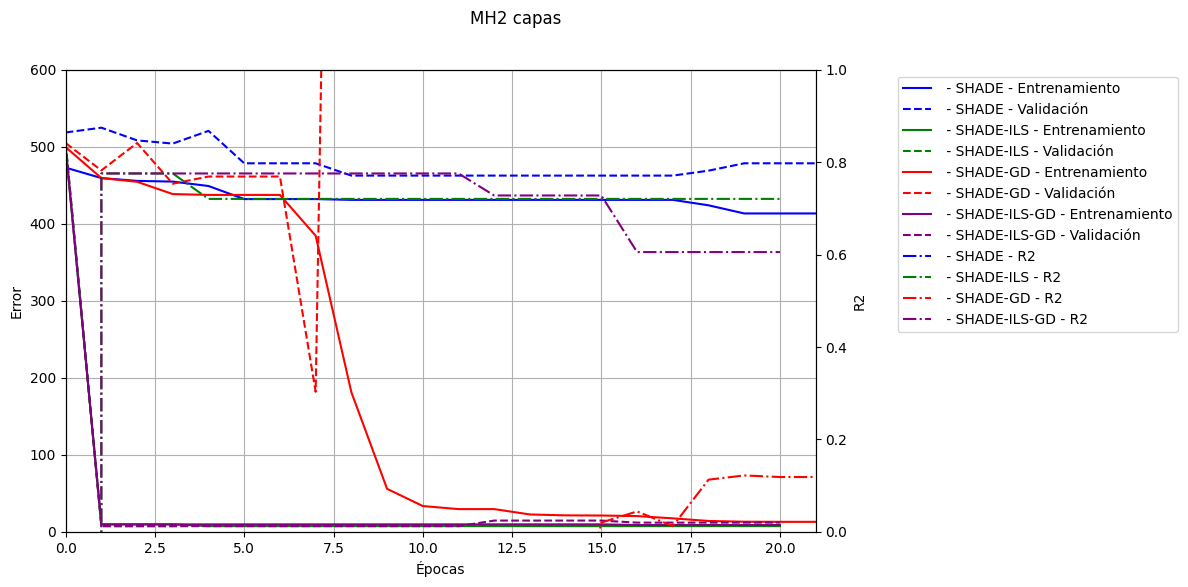

<Figure size 1200x600 with 0 Axes>

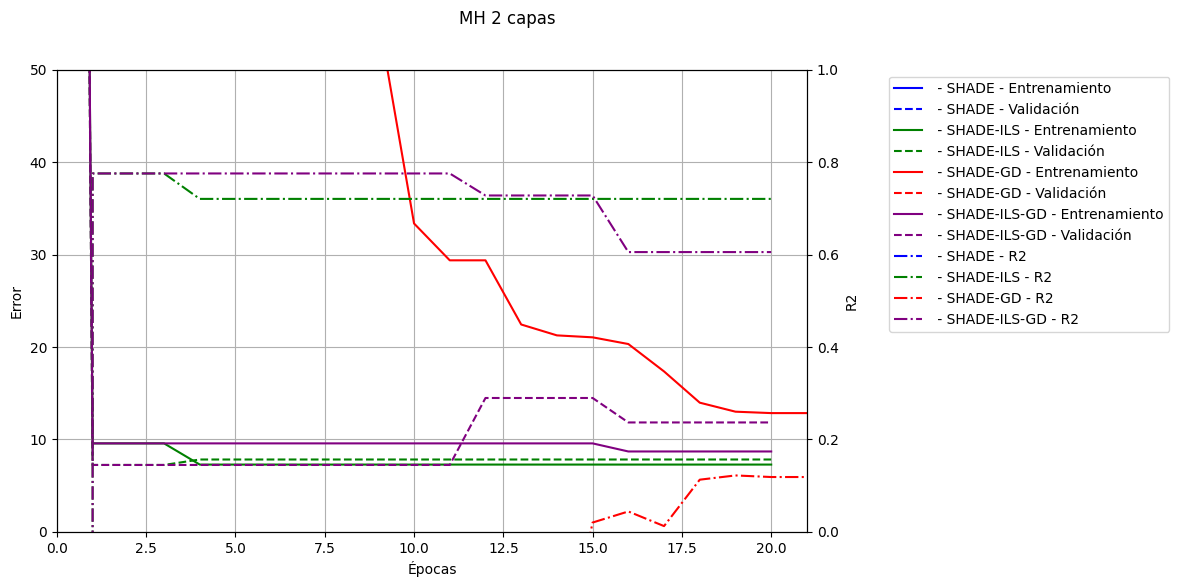

<Figure size 1200x600 with 0 Axes>

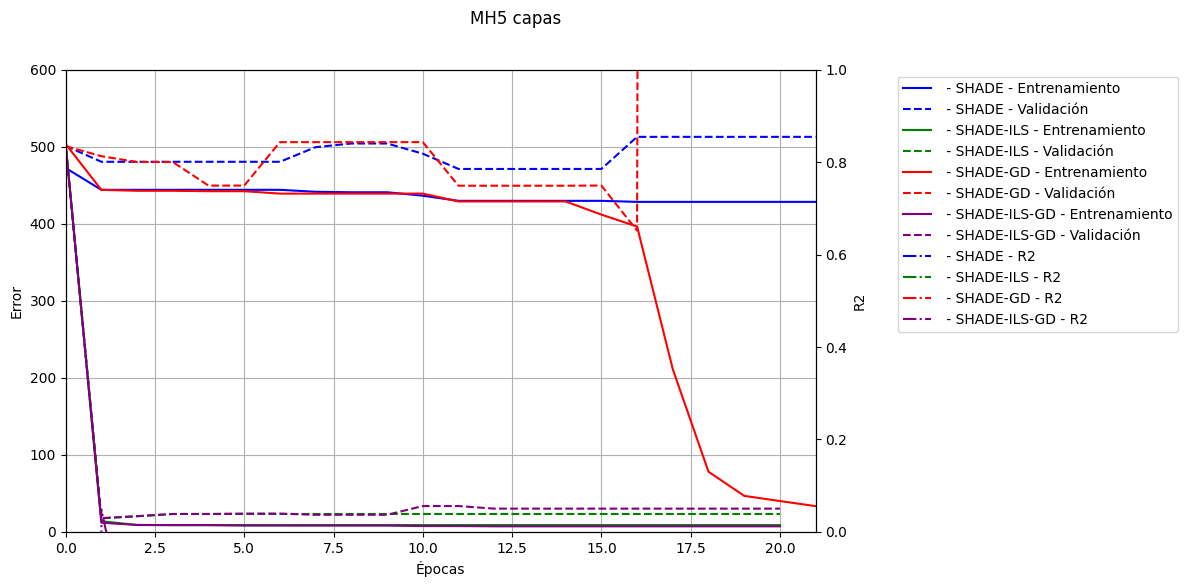

<Figure size 1200x600 with 0 Axes>

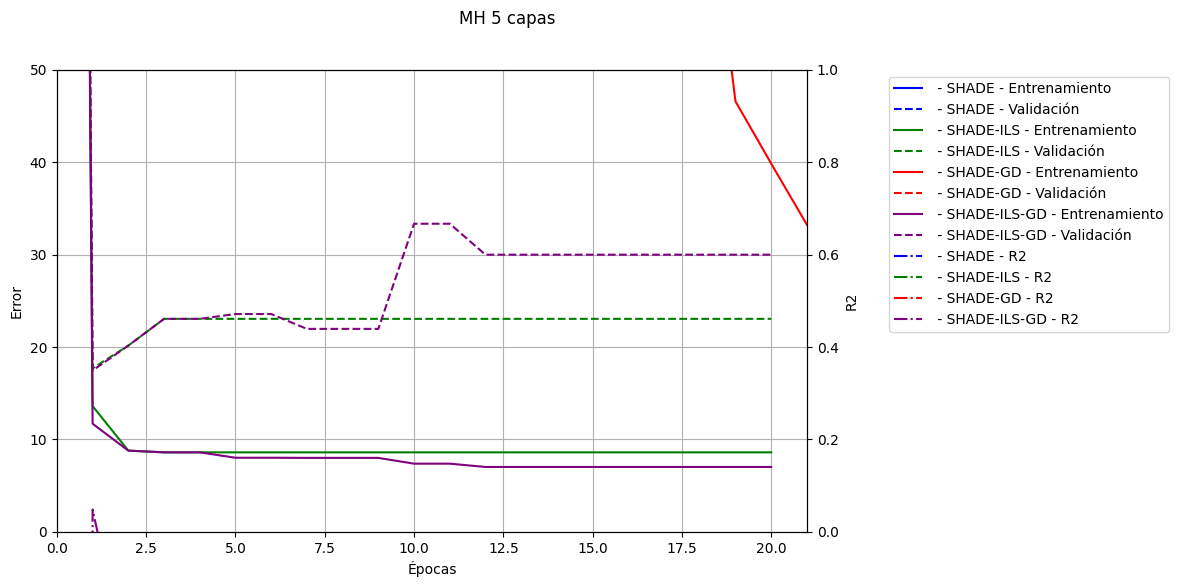

<Figure size 1200x600 with 0 Axes>

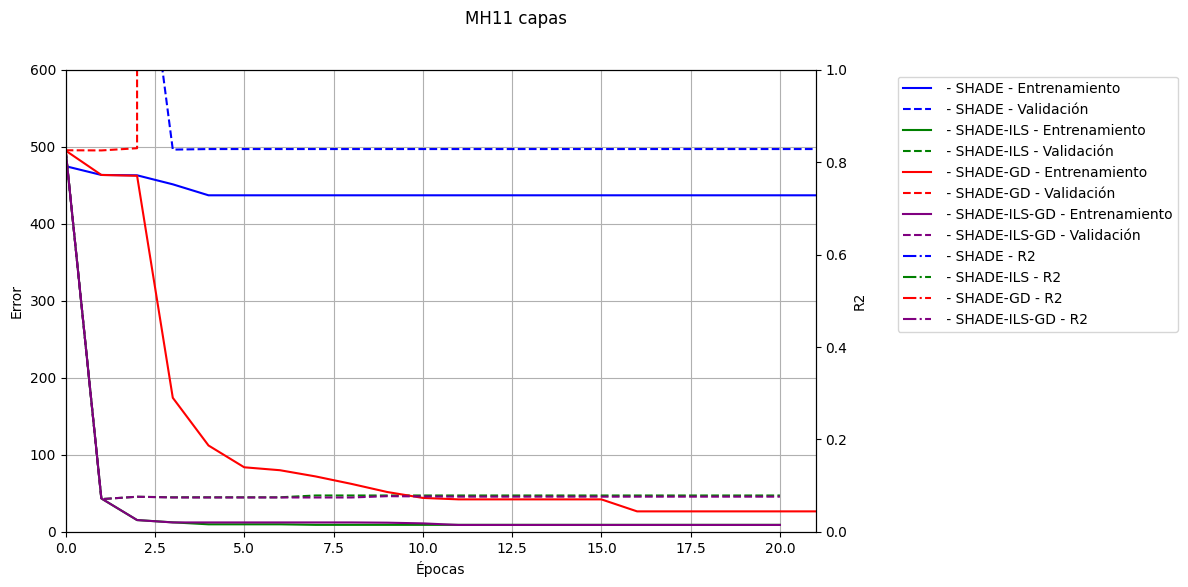

<Figure size 1200x600 with 0 Axes>

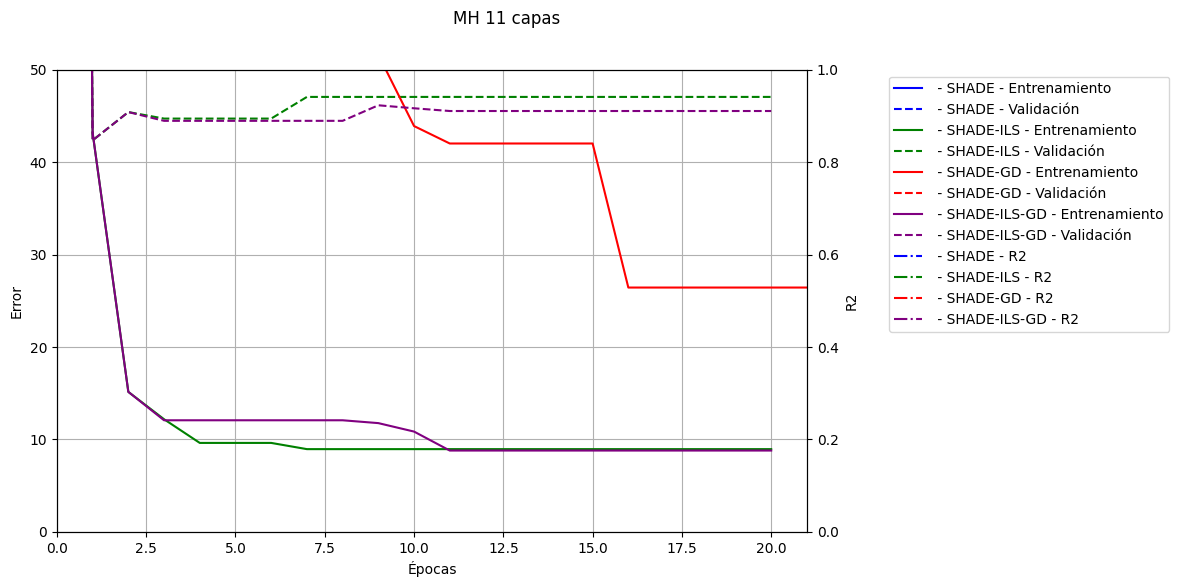

In [32]:
#Comparing the different MH for the same layer number

names= ['SHADE', 'SHADE-ILS', 'SHADE-GD', 'SHADE-ILS-GD']
train = {}
r2 = {}
valid = {}
for layer in n_layers:
  train[layer] = {}
  r2[layer] = {}
  valid[layer] = {}
  for alg in algs:
    train[layer][alg] = training[alg][layer]
    r2[layer][alg] = r2sq[alg][layer]
    valid[layer][alg] = fitness_valid[alg][layer]
  c = 'capa' if layer==1 else 'capas'
  utilsTFG.plot_mh_mlp_training(train[layer], valid[layer], r2[layer], lim=600, metric=['R2Square'], layers = names, names=names, title=f'MH{layer} {c}')
  utilsTFG.plot_mh_mlp_training(train[layer], valid[layer], r2[layer], lim=50, metric=['R2Square'], layers = names, names=names, title=f'MH {layer} {c}')

### Generalization

In [37]:
#Run the model in the test set
for mh in algs:
  for layer in n_layers:
    #Run the model with optimizer optim and n_layers layer the test set in evaluation mode
    utilsTFG.set_params_to_model(best[mh][layer], mh_learners[layer].model)
    mh_learners[layer].model.eval()
    mh_learners[layer].eval()
    preds, targs = mh_learners[layer].get_preds(dl=test_dl)
    targs = targs.long().squeeze()

    #Calculate balanced accuracy

    ac = utilsTFG.adjusted_r2_score(preds, targs)

    #Calculate F1-Score
    #f1 = utilsTFG.f1_score_func(preds, targs)

    loss = utilsTFG.err_param_w_model(mh_learners[layer].model, test_dl, mode = 'test', task='reg')

    print(f"Optimizer: {mh}, Layers: {layer}, Loss: {loss}, R2 Square: {ac}")

Optimizer: SHADE, Layers: 1, Loss: 452.3663330078125, R2 Square: -19228.340037722926


Optimizer: SHADE, Layers: 2, Loss: 428.2257385253906, R2 Square: -960.7181478671719


Optimizer: SHADE, Layers: 5, Loss: 435.000244140625, R2 Square: -7317.818717448118


Optimizer: SHADE, Layers: 11, Loss: 454.7857666015625, R2 Square: -53812929.90764937


Optimizer: SHADE-ILS, Layers: 1, Loss: 7.549042701721191, R2 Square: 0.5761260837055971


Optimizer: SHADE-ILS, Layers: 2, Loss: 4.648552894592285, R2 Square: 0.746614926061465


Optimizer: SHADE-ILS, Layers: 5, Loss: 14.555760383605957, R2 Square: -0.18712835968245423


Optimizer: SHADE-ILS, Layers: 11, Loss: 26.794395446777344, R2 Square: -97.4046264757975


Optimizer: SHADE-GD, Layers: 1, Loss: 33.098548889160156, R2 Square: 0.6504559340623381


Optimizer: SHADE-GD, Layers: 2, Loss: 128.8075714111328, R2 Square: -4.609790747034166


Optimizer: SHADE-GD, Layers: 5, Loss: 324.056396484375, R2 Square: -0.9317457171209131


Optimizer: SHADE-GD, Layers: 11, Loss: 453.8909912109375, R2 Square: -129350.49679739724


Optimizer: SHADE-ILS-GD, Layers: 1, Loss: 3.894911289215088, R2 Square: 0.8486777052620839


Optimizer: SHADE-ILS-GD, Layers: 2, Loss: 4.648552894592285, R2 Square: 0.746614926061465


Optimizer: SHADE-ILS-GD, Layers: 5, Loss: 14.36807632446289, R2 Square: -0.07834650136745003


Optimizer: SHADE-ILS-GD, Layers: 11, Loss: 26.794395446777344, R2 Square: -97.4046264757975


## Time comparison

In [38]:
#Compare times for each algorithm and layer

#GD
for alg, time_layers in time_mh.items():
  for layer, time in time_layers.items():
    print(f'Time consumed by {alg} training with {layer} layers: {time:.04f} seconds')

#MH
for optims, time_layers in time_gd.items():
  for layer, time in time_layers.items():
    print(f'Time consumed by {optims} training with {layer} layers: {time:.04f} seconds')



Time consumed by SHADE training with 1 layers: 52.9517 seconds
Time consumed by SHADE training with 2 layers: 57.9708 seconds
Time consumed by SHADE training with 5 layers: 100.3582 seconds
Time consumed by SHADE training with 11 layers: 728.5587 seconds
Time consumed by SHADE-ILS training with 1 layers: 55.7305 seconds
Time consumed by SHADE-ILS training with 2 layers: 61.1731 seconds
Time consumed by SHADE-ILS training with 5 layers: 109.4411 seconds
Time consumed by SHADE-ILS training with 11 layers: 832.3776 seconds
Time consumed by SHADE-GD training with 1 layers: 62.2158 seconds
Time consumed by SHADE-GD training with 2 layers: 66.3405 seconds
Time consumed by SHADE-GD training with 5 layers: 109.2263 seconds
Time consumed by SHADE-GD training with 11 layers: 733.0016 seconds
Time consumed by SHADE-ILS-GD training with 1 layers: 65.4284 seconds
Time consumed by SHADE-ILS-GD training with 2 layers: 68.9615 seconds
Time consumed by SHADE-ILS-GD training with 5 layers: 122.5460 seco

In [24]:
#GD
for alg, time_layers in time_full_mh.items():
  for layer, time in time_layers.items():
    print(f'Time consumed by {alg} training with {layer} layers: {time:.03f} seconds')

Time consumed by SHADE training with 1 layers: 55.261 seconds
Time consumed by SHADE training with 2 layers: 60.528 seconds
Time consumed by SHADE training with 5 layers: 103.264 seconds
Time consumed by SHADE training with 11 layers: 734.137 seconds
Time consumed by SHADE-ILS training with 1 layers: 56.217 seconds
Time consumed by SHADE-ILS training with 2 layers: 61.645 seconds
Time consumed by SHADE-ILS training with 5 layers: 110.071 seconds
Time consumed by SHADE-ILS training with 11 layers: 833.789 seconds
